In [7]:
import os
import json
import glob
import copy
import copy
import itertools
import re
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils
from pipeline.python.classifications import decode_utils as dec

from matplotlib.lines import Line2D
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [8]:
%matplotlib notebook

In [9]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()
pl.rcParams['axes.labelsize']

16.0

# Dataset info

In [10]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Responsive params
responsive_test = 'nstds' # 'nstds' #'ROC' #None
nstd_thr=10
responsive_thr = nstd_thr if responsive_test=='nstds' else 0.05 #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

response_type = 'dff'

response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
print(response_str)

##### Pick datasets for experiment
experiment = 'blobs'
stim_filterby = None #'first'
if experiment=='blobs':
    has_gratings=False
    g_str = 'hasgratings' if has_gratings else 'blobsonly'
else:
    g_str = 'gratingsonly'
resp_filter_str = 'stim-filter-%s_%s_%s' % (stim_filterby, g_str, response_str)


#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, resp_filter_str])
print(data_id)

dff_nstds-thr-10.00
traces001|stim-filter-None_blobsonly_dff_nstds-thr-10.00


# Output dir

In [11]:
pupildir = os.path.join(aggregate_dir, 'behavior-state', 'pupil')
print(pupildir)

if not os.path.exists(pupildir):
    os.makedirs(pupildir)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/pupil


#### Get metadata for stimulus

In [12]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

# Get blob metadata only - and only if have RFs
sdata_exp = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ])
print(sdata_exp[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count())


             animalid  session  fov
visual_area                        
Li                 13       13   13
Lm                 12       12   12
V1                 11       11   11


In [8]:
# Drop duplicates and whatnot fovs
if experiment=='blobs':
    exp_dkeys = aggr.get_blob_datasets(filter_by=stim_filterby, has_gratings=has_gratings, as_dict=True)
elif experiment == 'gratings':
    exp_dkeys = aggr.get_gratings_datasets(filter_by=stim_filterby, as_dict=True)

dictkeys = [d for d in list(itertools.chain(*exp_dkeys.values()))]
stim_datakeys = sdata_exp[sdata_exp['datakey'].isin(dictkeys)]['datakey'].unique()
expmeta = dict((k, [dv for dv in stim_datakeys for vv in v if vv in dv]) for k, v in exp_dkeys.items())

edata = sdata_exp[sdata_exp['datakey'].isin(stim_datakeys)].copy().reset_index(drop=True)
print('[%s] %i unique datakeys' % (experiment, len(stim_datakeys)))
edata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

[blobs] 36 unique datakeys


,animalid,session,fov
visual_area,,,
Li,13,13,13
Lm,12,12,12
V1,11,11,11


# Load data

In [13]:
from pipeline.python.retinotopy import segment_retinotopy as seg
from pipeline.python.classifications import dlc_utils as dlcutils

ImportError: cannot import name dlc_utils

#### Neural data

In [10]:
# Neural data
trial_epoch = 'stimulus'
MEANS = aggr.load_aggregate_data(experiment, responsive_test=responsive_test, responsive_thr=responsive_thr, 
               response_type=response_type, epoch=trial_epoch)
MEANS = aggr.equal_counts_per_condition(MEANS)


...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl


In [11]:
# ROI assignments
rois = seg.get_cells_by_area(sdata_exp)
cells = aggr.get_active_cells_in_current_datasets(rois, MEANS)


Segmentation, missing:
20190502_JC076_fov1
20191008_JC091_fov1


In [12]:
# glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_baseline.pkl' 
#                                                % (experiment, responsive_test, response_type)))

In [13]:
# aggr_baselines_dfile = glob.glob(os.path.join(stats_dir, 
#                                 'aggr_%s_trialmeans_*%s*_%s_baseline.pkl'
#                                               % (experiment, responsive_test, response_type)))[0]

# print(aggr_baselines_dfile)
# with open(aggr_baselines_dfile, 'rb') as f:
#     BAS = pkl.load(f)

#### Face tracker data

In [14]:
reload(dlcutils)

<module 'pipeline.python.classifications.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/dlc_utils.pyc'>

In [15]:
#### Face tracker data
# -----------------------------------------------------------
feature_name = 'pupil_area'
snapshot = 391800
# -----------------------------------------------------------

#### Only include dsets with face-tracking
dsets = dlcutils.get_datasets_with_dlc(edata)
dlc_datakeys = dsets['datakey'].unique()
exp_datakeys = edata['datakey'].unique()
print("%i of %i datasets with DLC." % (len(dlc_datakeys),len(exp_datakeys)))
missing_dlc = [i for i in exp_datakeys if i not in dlc_datakeys]
print("Need %i datasets analyzed:" % len(missing_dlc), missing_dlc)

#### Loading existing extracted pupil traces (dict)
pupiltraces = dlcutils.load_pupil_traces(experiment=experiment, feature_name=feature_name, snapshot=snapshot)

#### Check for any missing dkeys
missing_dlc = [i for i in exp_datakeys if '%s_%s' % (i, experiment) not in pupiltraces.keys()]
print("Missing %i datasets for DCL extraction:" % len(missing_dlc))
for i in missing_dlc: print('... %s' % i);

Extracting results from scorer: DLC_resnet50_facetrackingJan25shuffle1_391800
Checking for existing results: /n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis
35 of 36 datasets with DLC.
('Need 1 datasets analyzed:', ['20191008_JC091_fov1'])
Missing 1 datasets for DCL extraction:
... 20191008_JC091_fov1


In [16]:
# # Add FRACTION area
# for k, v in pupiltraces.items():
#     pupil_max = v['pupil_area'].max()
#     pupiltraces[k]['pupil_fraction'] = v['pupil_area']/pupil_max

face_feature='pupil_fraction' if feature_name=='pupil_area' else feature_name
pupil_epoch='pre'
pupildata = dlcutils.load_pupil_data(experiment=experiment, feature_name=face_feature, trial_epoch=pupil_epoch,
                                     snapshot=snapshot, create_new=False)

In [17]:
pupildata[pupildata.keys()[0]].head()

,trial,frame,pupil_fraction,frame_int,frame_ix
0,1.0,9.5,0.511238,9.5,9.5
1,2.0,9.5,0.389683,9.5,9.5
2,3.0,9.5,0.361294,9.5,9.5
3,4.0,9.5,0.195588,9.5,9.5
4,5.0,9.5,0.195596,9.5,9.5


# Check trial counts

In [18]:
datakey='20190616_JC097_fov1'
visual_area='V1'
pupildf = pupildata[datakey].copy()
neuraldf = aggr.get_neuraldf_for_cells_in_area(cells, MEANS, datakey=datakey, visual_area=visual_area)
print(neuraldf.shape, pupildf.shape)

((1500, 295), (1675, 5))


In [19]:
neuraldf, pupildf = dlcutils.match_trials_df(neuraldf, pupildf, equalize_conditions=True)
print(neuraldf.shape, pupildf.shape)

((1500, 295), (1500, 5))


In [20]:
neuraldf['config'].value_counts().unique()

array([30])

In [21]:
pupil_low, pupil_high = dlcutils.split_pupil_range(pupildf, feature_name=face_feature, n_cuts=3)
low_trial_ixs = pupil_low['trial'].unique()
high_trial_ixs = pupil_high['trial'].unique()
all_trial_ixs = pupildf['trial'].unique()

print(len(all_trial_ixs), len(low_trial_ixs), len(high_trial_ixs))


(1500, 500, 500)


In [22]:
arousal_conds = ['all', 'low', 'high']
arousal_trial_ixs = [all_trial_ixs, low_trial_ixs, high_trial_ixs]

for arousal_cond, curr_trial_ixs in zip(arousal_conds, arousal_trial_ixs):
    curr_data = neuraldf.loc[curr_trial_ixs].copy()

    print(arousal_cond, curr_data.shape)
    

('all', (1500, 295))
('low', (500, 295))
('high', (500, 295))


In [23]:
neuraldf.loc[low_trial_ixs]['config'].value_counts().unique()

array([14, 13, 12, 11, 10,  9,  8,  7,  6,  5])

In [24]:
sizes_low = [sdf['size'][cfg] for cfg in neuraldf.loc[low_trial_ixs]['config']]
sizes_high = [sdf['size'][cfg] for cfg in neuraldf.loc[high_trial_ixs]['config']]
morphs_low = [sdf['morphlevel'][cfg] for cfg in neuraldf.loc[low_trial_ixs]['config']]
morphs_high = [sdf['morphlevel'][cfg] for cfg in neuraldf.loc[high_trial_ixs]['config']]

f, axn = pl.subplots(1,2)
ax=axn[0]
ax.set_title('size')
sns.distplot(sizes_low, bins=5, kde=False, color='m', label='low', ax=ax)
sns.distplot(sizes_high, bins=5, kde=False, color='b', label='high', ax=ax)
ax.legend()

ax=axn[1]
ax.set_title('morphs')
sns.distplot(morphs_low, bins=9, kde=False, color='m', label='low', ax=ax)
sns.distplot(morphs_high, bins=9, kde=False, color='b', label='high', ax=ax)
ax.legend()

NameError: name 'sdf' is not defined

In [166]:
min(morphs_high)


-1

In [169]:
class_a=0
class_b=106
train_configs = sdf[sdf['morphlevel'].isin([class_a, class_b])].index.tolist()


In [170]:
for arousal_cond, curr_trial_ixs in zip(arousal_conds, arousal_trial_ixs):
    curr_data = neuraldf.loc[curr_trial_ixs].copy()
    
    sample_data = curr_data[curr_data['config'].isin(train_configs)]
    print(arousal_cond, sample_data.shape)

('all', (300, 295))
('low', (100, 295))
('high', (93, 295))


# This is tmp, xtract pupil info

In [29]:
# Get trial alignment info
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC097'
session = '20190616'
fovnum = 1
alignment_info = aggr.get_trial_alignment(animalid, session, fovnum, experiment, traceid=traceid)
# alignment_info
iti_pre_ms = float(alignment_info['iti_pre'])*1000
iti_post_ms = float(alignment_info['iti_post'])*1000
print("ITI pre/post: %.1f ms, %.1f ms" % (iti_pre_ms, iti_post_ms))

ITI pre/post: 1000.0 ms, 1000.0 ms


In [28]:
if len(missing_dlc) > 0:
    for dkey in missing_dlc:
        print("[%s] getting extracted feature: %s" % (dkey, face_feature))
        session, animalid, fov = dkey.split('_')
        fovnum = int(fov[3:])
        fov = 'FOV%i_zoom2p0x' % fovnum

        #### Get labels
        labels_dfile = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_*%s*' % experiment, 'traces',
                              '%s*' % traceid, 'data_arrays', 'labels.npz'))[0]
        l = np.load(labels_dfile)
        labels = pd.DataFrame(data=l['labels_data'], columns=l['labels_columns'])

        #### Load pupil data
        facemeta, pupildata = dlcutils.load_pose_data(animalid, session, fovnum, experiment, dlc_results_dir, 
                                                      feature_list=[face_feature], epoch='trial_alignment', 
                                                      pre_ITI_ms=iti_pre_ms, post_ITI_ms=iti_post_ms)

        #### Parse pupil data into traces
        pupiltraces = dlcutils.get_pose_traces(facemeta, pupildata, labels, feature='pupil_area')

        #### Add to dict
        datakey ='%s_%s_fov%i_%s' % (session, animalid, fovnum, experiment)  
        PUPIL[datakey] = pupiltraces


    # This is a dict, keys are datakeys
    with open(pupil_fpath, 'wb') as f:
        pkl.dump(PUPIL, f, protocol=pkl.HIGHEST_PROTOCOL)


In [16]:
for dkey in sdata_exp[sdata_exp['visual_area']=='V1']['datakey'].unique():
    if '%s_%s' % (dkey, experiment) not in PUPIL.keys():
        print("missing: %s" % dkey)
        continue
    pupil_min = PUPIL['%s_%s' % (dkey, experiment)]['pupil_area'].min()
    pupil_max = PUPIL['%s_%s' % (dkey, experiment)]['pupil_area'].max()
    print('%s: %.2f/1 (%.2f, %.2f)' % (dkey, pupil_min/pupil_max, pupil_min, pupil_max))


20190420_JC076_fov1: 0.01/1 (29.75, 2698.85)
20190501_JC076_fov1: 0.03/1 (43.80, 1512.63)
20190507_JC083_fov1: 0.04/1 (60.30, 1684.06)
20190510_JC083_fov1: 0.05/1 (41.70, 805.37)
20190511_JC083_fov1: 0.05/1 (64.24, 1310.26)
20190522_JC084_fov1: 0.04/1 (55.07, 1512.62)
20190622_JC085_fov1: 0.05/1 (243.54, 5292.63)
20190613_JC097_fov1: 0.02/1 (59.93, 3151.94)
20190616_JC097_fov1: 0.02/1 (91.62, 4433.13)
20190617_JC097_fov1: 0.02/1 (79.53, 4994.47)
20191006_JC110_fov1: 0.02/1 (56.28, 3600.42)


# Check alignment...

In [25]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

In [26]:
iti_pre=1
stim_dur=1
A = aggr.aggregate_alignment_info(edata)
aligned_keys = A[(A['iti_pre']==iti_pre) & (A['stim_dur']==stim_dur)]['datakey'].unique()
len(aligned_keys)

Realign: 20190420_JC076_fov1


35

# Example FOV

In [27]:
include_stimuli='all'

animalid = 'JC097'
session = '20190616'
fovnum = 1
visual_area='V1'

# Get experiment info
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
if experiment == 'blobs':
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
else:
    obj = util.Gratings(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()
print(sdf.shape)

# Alignment info
alignment_info = aggr.get_trial_alignment(animalid, session, fovnum, experiment, traceid=traceid)
iti_pre_ms = float(alignment_info['iti_pre'])*1000
iti_post_ms = float(alignment_info['iti_post'])*1000
print("ITI pre/post: %.1f ms, %.1f ms" % (iti_pre_ms, iti_post_ms))

included_configs = putils.get_stimulus_configs(sdf, experiment=experiment, include_stimuli=include_stimuli)

(50, 8)
ITI pre/post: 1000.0 ms, 1000.0 ms
Restricting stimuli to: all (50 conditions)


In [79]:
# Get neural means
print(visual_area, datakey)
neuraldf = aggr.get_neuraldf_for_cells_in_area(cells, MEANS, datakey=datakey, visual_area=visual_area)
print("%s: %s (%i)" % (visual_area, datakey, (neuraldf.shape[1]-1)))

# Get pupil traces
pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()
print("Pupil traces: %s" % str(pupiltraces.shape))
pupiltraces.head()

('V1', '20190616_JC097_fov1')
V1: 20190616_JC097_fov1 (294)
Pupil traces: (91905, 4)


,config,pupil_area,trial,pupil_fraction
0,config004,2487.177261,1,0.561043
1,config004,2555.161442,1,0.576379
2,config004,2522.725502,1,0.569062
3,config004,2649.618338,1,0.597686
4,config004,1881.843615,1,0.424496


## Resample traces

In [80]:
# Temporal binning params
face_framerate = 20.0
framerate = 44.65
print("Downsampled fr: %.2f Hz" % face_framerate)

Downsampled fr: 20.00 Hz


In [81]:
datakey

'20190616_JC097_fov1'

In [82]:
#### Load traces of responsive cells
print("Loading <%s> traces: test=%s, thr=%.3f" % (response_type, responsive_test, responsive_thr))
traces, labels_all, sdf = aggr.load_traces(animalid, session, fovnum, experiment, traceid=traceid, 
                                         response_type=response_type,
                                         responsive_test=responsive_test, 
                                         responsive_thr=responsive_thr)
labels_all['trial_num'] = [int(t[5:]) for t in labels_all['trial']]
trial_key = dict((int(t[5:]), g['config'].unique()[0]) for t, g in labels_all.groupby(['trial']))
roi_list = cells[cells['datakey']==datakey]['cell'].unique()
traces = traces[roi_list]

# Make sure trials match between pupil and neural
trials_with_pupil = list(pupiltraces['trial'].unique())
labels = labels_all[labels_all['trial_num'].isin(trials_with_pupil)].copy()

Loading <dff> traces: test=nstds, thr=10.000
... exp.load()
... loading saved data array (dff).
... updating self
... getting responsive cells (test: nstds, thr: 10.00')
... loading stats
296 of 432 cells responsive


In [83]:
#### Get trial epochs
stim_on = float(labels['stim_on_frame'].unique())
n_on = float(labels['nframes_on'].unique())
iti_pre = float(alignment_info['iti_pre'])
iti_post = float(alignment_info['iti_post'])
stim_dur = stim_on/framerate
new_stim_on = (iti_pre)*face_framerate #int(np.where(abs(out_ixs-stim_on) == min(abs(out_ixs-stim_on)))[0])
desired_nframes = int( (stim_dur + iti_pre + iti_post)*face_framerate)
print(new_stim_on)

20.0


### (Example) Test traces

In [85]:
rid=90 #182 #90

In [91]:
# Check with known config, known RID
ml=40 #-1
sz=20
# --------------------------------

cfg = sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)].index[0]
trial_ixs_currcfg = np.array([int(t[5:]) for t in labels[labels['config']==cfg]['trial'].unique()])
trial_ixs = np.array([t for t in trial_ixs_currcfg if t in trials_with_pupil])
print("[%s] plotting %i of %i trials" % (cfg, len(trial_ixs), len(trial_ixs_currcfg)))

[config022] plotting 30 of 30 trials


In [92]:
# Resample neural traces
curr_roi_traces = dlcutils.resample_neural_traces(traces[rid], labels, 
                                         in_rate=framerate, out_rate=face_framerate, zscore=True)


In [93]:
# Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
roi_traces=traces[rid].copy()
trialmat = pd.DataFrame(np.vstack([roi_traces[tg.index] for trial, tg in labels.groupby(['trial'])]),\
                        index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])

# Create trial mat for resampled traces
binned_trialmat = dlcutils.roi_traces_to_trialmat(curr_roi_traces, trial_ixs)
binned_trialmat = pd.DataFrame(binned_trialmat, index=trial_ixs)


In [94]:
binned_trialmat.shape

(30, 60)

<IPython.core.display.Javascript object>


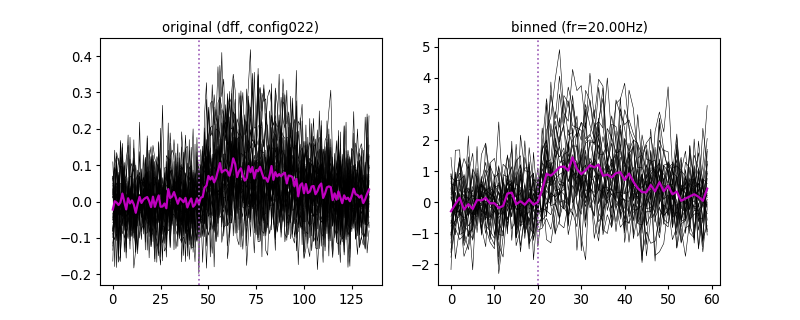

In [95]:
fig, axn = pl.subplots(1, 2, figsize=(10,4))
ax=axn[0]; ax.set_title('original (%s, %s)' % (response_type, cfg));
ax.plot(trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(trialmat.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=stim_on, ls=':')


ax=axn[1]; ax.set_title('binned (fr=%.2fHz)' % (face_framerate));
ax.plot(binned_trialmat.T, 'k', lw=0.5)
ax.plot(np.nanmean(binned_trialmat, axis=0), 'm', lw=2)
ax.axvline(x=new_stim_on, ls=':')

# ax=axn[2]; ax.set_title('zscored');
# ax.plot(curr_roi_traces.loc[trial_ixs].values.T, 'k', lw=0.5)
# ax.plot(np.nanmean(curr_roi_traces.loc[trial_ixs].values.T, axis=0), 'm', lw=2)
# ax.axvline(x=new_stim_on, ls=':')
# pl.subplots_adjust(top=0.8)
# pl.suptitle('rid %i' % rid)


### (Example) Match pupil framerate

#### Resample pupil

In [96]:
reload(dlcutils)

<module 'pipeline.python.classifications.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/dlc_utils.pyc'>

In [99]:
pupil_epoch='pre'
face_feature='pupil_fraction'

face_framerate=20.
desired_nframes = 60 #len(out_ixs) # 60

# Temporal binning params
new_framerate = 20.0
framerate = 44.65

#### Resample pupil
binned_pupil = dlcutils.bin_pupil_traces(pupiltraces, feature_name=face_feature,
                                     in_rate=face_framerate, out_rate=face_framerate, 
                                     min_nframes=desired_nframes, iti_pre_ms=iti_pre_ms)
new_stim_on = binned_pupil['stim_on'].unique()[0]
print("New stimulus on: %i" % new_stim_on)
pupil_r = dlcutils.resample_pupil_traces(pupiltraces, in_rate=face_framerate, out_rate=face_framerate, 
                               desired_nframes=desired_nframes, feature_name=face_feature, 
                               iti_pre_ms=iti_pre_ms)
pupildf = dlcutils.get_pupil_df(pupil_r, trial_epoch=pupil_epoch, new_stim_on=new_stim_on)

#### Make sure neural df matches
neuraldf=neuraldf.loc[trials_with_pupil]

#### Filter out trials with no pupil info or no neural
neuraldf, pupiltraces = dlcutils.match_trials(neuraldf, pupiltraces, labels_all)

New stimulus on: 20


<IPython.core.display.Javascript object>


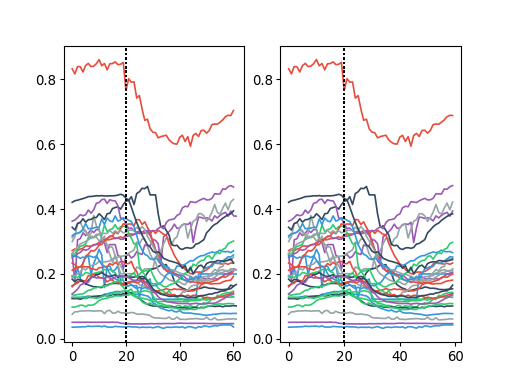

In [100]:
fig, axn = pl.subplots(1, 2)
ax=axn[0]
for t, pg in pupiltraces[pupiltraces['config']==cfg].groupby(['trial']):
    ixs = np.arange(0, len(pg[face_feature].values))
    ax.plot(ixs, pg[face_feature].values)
    ax.axvline(x=new_stim_on, ls=':', color='k')
    
ax=axn[1]
for t, pg in binned_pupil[binned_pupil['config']==cfg].groupby(['trial']):
    ixs = np.arange(0, len(pg[face_feature].values))
    ax.plot(ixs, pg[face_feature].values)
    ax.axvline(x=new_stim_on, ls=':', color='k')

In [101]:
binned_trialmat.shape

(30, 60)

In [102]:
#### Create trialmat for selected trials (pupil)
pupil_trialmat = pd.DataFrame(np.vstack([p[face_feature].values 
                                         for trial, p in binned_pupil.groupby(['trial'])]),
                              index=trialmat.index)
print(pupil_trialmat.shape)


(1500, 60)


<IPython.core.display.Javascript object>


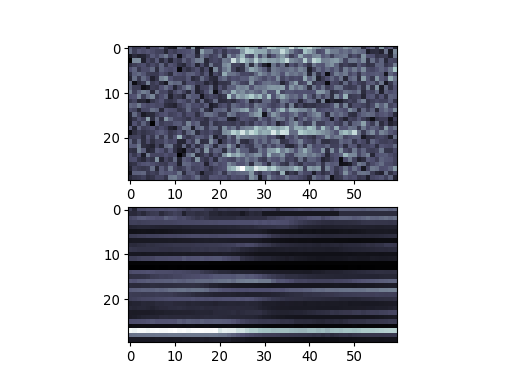

In [103]:
fig, axn = pl.subplots(2, 1)
ax=axn[0]
ax.imshow(binned_trialmat.loc[trial_ixs], cmap='bone')
ax=axn[1]
ax.imshow(pupil_trialmat.loc[trial_ixs], cmap='bone')


# Create data frames for pupil/neural data - test low/high pupil

In [105]:
n_cuts=3

# ------ Split trials by quantiles ---------------------------------
quantile_bins, pupil_low, pupil_high = dlcutils.split_pupil_range(pupildf, feature_name=face_feature, 
                                                           n_cuts=n_cuts, return_bins=True)
# Get quantile values
pupil_quantiles = pupildf[face_feature].quantile(quantile_bins)

# Can also bin into low, mid, high for visualization
pupildf['quantile'] = pd.qcut(pupildf[face_feature], n_cuts, labels=False)

In [106]:
pupil_quantiles

0.333333    0.169550
0.666667    0.266584
Name: pupil_fraction, dtype: float64

## Subdivide pupil levels into high/low

<IPython.core.display.Javascript object>


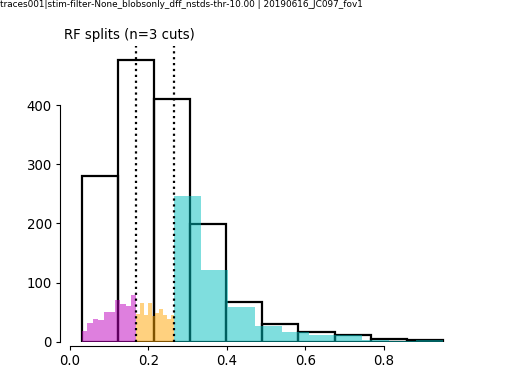

In [107]:

fig, ax = pl.subplots()
ax.hist(pupildf[face_feature], edgecolor='k', facecolor='none', lw=2)
for v in pupil_quantiles:
    ax.axvline(x=v, ls=':', color='k', lw=2)
    
qcolors = ['m', 'orange', 'c', 'b']
for col, (i, pg) in zip(qcolors, pupildf.groupby(['quantile'])):
    ax.hist(pg[face_feature].values, color=col, alpha=0.5)
    
    
sns.despine(trim=True, offset=4)
ax.set_title('RF splits (n=%i cuts)' % n_cuts, loc='left')
putils.label_figure(fig, '%s | %s' % (data_id, datakey))

In [172]:
p = PUPIL.keys()[0]
p

'20190603_JC080_fov1_blobs'

In [178]:
pupildf.shape

(1675, 5)

# Decode classes, split arousal state

In [14]:
import random
import scipy.stats as spstats
import sklearn.metrics as skmetrics

from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve, ShuffleSplit
from sklearn.svm import LinearSVC
#from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from pipeline.python.classifications import decode_utils as dec

In [15]:
reload(dec)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.pyc'>

In [16]:
def fit_classifier_bootstrap(curr_data, sdf, m0=0, m100=106, cv_nfolds=5, test_size=0.2, 
                             C_value=1.0, n_iterations=50):
    iter_list=[]; chance_list=[];
    for iteration in np.arange(0, n_iterations):

        #### Select train/test configs for clf A vs B
        object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
        curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
        sample_data = curr_data[curr_data['config'].isin(object_configs)]

        #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
        data = sample_data[curr_roi_list]
        zdata = (data - data.mean()) / data.std()

        #### Get labels
        targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
        targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]
        targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]
        
        #### Fit
        randi=random.randint(1, 10000)
        curr_iter, curr_iter_chance = dec.fit_svm_shuffle(zdata, targets, C_value=C_value, 
                                                          test_split=test_size, randi=randi)
        
        #### Add
        iter_list.append(pd.DataFrame(curr_iter, index=[iteration]))
        chance_list.append(pd.DataFrame(curr_iter_chance, index=[iteration]))
        
    # DATA - get mean across iters
    iter_results = pd.concat(iter_list, axis=0)
    iterdict = dict(iter_results.mean())
    iterdict.update( dict(('%s_std' % k, v) for k, v in \
                          zip(iter_results.std().index, iter_results.std().values)) )
    iterdict.update( dict(('%s_sem' % k, v) for k, v in \
                          zip(iter_results.sem().index, iter_results.sem().values)) )


    # CHANCE - get mean across iters
    iter_results_chance = pd.concat(chance_list, axis=0)
    iterdict_chance = dict(iter_results_chance.mean())
    iterdict_chance.update( dict(('%s_std' % k, v) for k, v in \
                          zip(iter_results_chance.std().index, iter_results_chance.std().values)) )
    iterdict_chance.update( dict(('%s_sem' % k, v) for k, v in \
                          zip(iter_results_chance.sem().index, iter_results_chance.sem().values)) )
    
    iterdict.update({'class_a': m0, 'class_b': m100})
    iterdict_chance.update({'class_a': m0, 'class_b': m100})
      
    return iterdict, iterdict_chance # df, df_chance


# def fit_classifier_bootstrap(curr_data, sdf, m0=0, m100=106, cv_nfolds=5, test_size=0.2, 
#                              C_value=1.0, n_iterations=50, class_a=0, class_b=106):
#     iter_list=[]; chance_list=[];
#     for iteration in np.arange(0, n_iterations):
#         #### Fit
#         curr_iter, curr_iter_chance = dec.do_fit_within_fov(iteration,
#                                                             curr_data=curr_data, sdf=sdf, C_value=C_value, 
#                                                           return_shuffle=True, 
#                                                           test_split=test_size, cv_nfolds=cv_nfolds,
#                                                            class_a=m0, class_b=m100)
        
#         #### Add
#         iter_list.append(pd.DataFrame(curr_iter, index=[iteration]))
#         chance_list.append(pd.DataFrame(curr_iter_chance, index=[iteration]))
        
#     # DATA - get mean across iters
#     iter_results = pd.concat(iter_list, axis=0)
#     iterdict = dict(iter_results.mean())
#     iterdict.update( dict(('%s_std' % k, v) for k, v in \
#                           zip(iter_results.std().index, iter_results.std().values)) )
#     iterdict.update( dict(('%s_sem' % k, v) for k, v in \
#                           zip(iter_results.sem().index, iter_results.sem().values)) )

#     # CHANCE - get mean across iters
#     iter_results_chance = pd.concat(chance_list, axis=0)
#     iterdict_chance = dict(iter_results_chance.mean())
#     iterdict_chance.update( dict(('%s_std' % k, v) for k, v in \
#                           zip(iter_results_chance.std().index, iter_results_chance.std().values)) )
#     iterdict_chance.update( dict(('%s_sem' % k, v) for k, v in \
#                           zip(iter_results_chance.sem().index, iter_results_chance.sem().values)) )
    
#     iterdict.update({'class_a': m0, 'class_b': m100})
#     iterdict_chance.update({'class_a': m0, 'class_b': m100})
      
#     return iterdict, iterdict_chance # df, df_chance

# Set output dir for decoding w.r.t. behavior state

In [17]:
decoding_dir = os.path.join(aggregate_dir, 'behavior-state', 'decoding')
if not os.path.exists(decoding_dir):
    os.makedirs(decoding_dir)
print(decoding_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding


In [18]:
# Get trial indices of low/high pupil 
low_trial_ixs = sorted(pupil_low['trial'].unique())
high_trial_ixs = sorted(pupil_high['trial'].unique())

print(pupil_low.shape, pupil_high.shape)


NameError: name 'pupil_low' is not defined

In [ ]:
m0=0
m100=106
C_value=1

n_iterations = 50
test_size=0.2
cv_nfolds=5

In [35]:
reload(dec)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.pyc'>

In [143]:
# Fit ALL
#curr_data = neuraldf.copy()
all_trial_ixs = neuraldf.index.tolist()

i=0
d_list=[]
shuf_list = []
for arousal, curr_trial_ixs in zip(['all', 'low', 'high'], [all_trial_ixs, low_trial_ixs, high_trial_ixs]):
    curr_data = neuraldf.loc[curr_trial_ixs].copy()
    iterdict, iterdict_chance = fit_classifier_bootstrap(curr_data, sdf, m0=m0, m100=m100, 
                                    n_iterations=n_iterations,
                                    cv_nfolds=cv_nfolds, test_size=test_size, C_value=C_value)
    iterdict['arousal'] = arousal
    iterdict_chance['arousal'] = arousal
    
    d_list.append(pd.DataFrame(iterdict, index=[i])) #df)
    shuf_list.append(pd.DataFrame(iterdict_chance, index=[i])) #df_chance)
                     
    i+=1

df = pd.concat(d_list, axis=0)
df_chance = pd.concat(shuf_list, axis=0)

print(df.shape, d_list[0].shape)

((3, 36), (1, 36))


In [144]:
df

,C,C_sem,C_std,arousal,class_a,class_b,fit_time,fit_time_sem,fit_time_std,heldout_MI,...,n_trials_std,score_time,score_time_sem,score_time_std,test_score,test_score_sem,test_score_std,train_score,train_score_sem,train_score_std
0,1.0,0.0,0.0,all,0,106,0.013876,0.000076,0.000535,0.138101,...,0.0,0.002243,0.000010,0.000074,0.741546,0.003236,0.022881,1.0,0.0,0.0
1,1.0,0.0,0.0,low,0,106,0.002946,0.000009,0.000063,0.073222,...,0.0,0.000704,0.000002,0.000014,0.650340,0.005848,0.041353,1.0,0.0,0.0
2,1.0,0.0,0.0,high,0,106,0.001334,0.000003,0.000019,0.120738,...,0.0,0.000420,0.000001,0.000008,0.703564,0.008728,0.061714,1.0,0.0,0.0


## Fit all morph pairs

In [127]:
morphs= [m for m in sdf['morphlevel'].unique() if m!=-1]
morph_pairs = list(itertools.combinations(morphs, 2))

# score_metrics = ['train_accuracy', 'test_accuracy', 'heldout_test_score', 'heldout_log2MI', 'heldout_aMI', 'heldout_MI']

# Fit ALL
all_trial_ixs = neuraldf.index.tolist()

d_list=[]
shuf_list = []
for (m0, m100) in morph_pairs:
    for arousal, curr_trial_ixs in zip(['all', 'low', 'high'], [all_trial_ixs, low_trial_ixs, high_trial_ixs]):
        curr_data = neuraldf.loc[curr_trial_ixs].copy()
        iterdict, iterdict_chance = fit_classifier_bootstrap(curr_data, sdf, m0=m0, m100=m100, 
                                            n_iterations=n_iterations, 
                                            cv_nfolds=cv_nfolds, test_size=test_size, C_value=C_value)
        iterdict['arousal'] = arousal
        iterdict_chance['arousal'] = arousal
        d_list.append(pd.DataFrame(iterdict, index=[i])) #df)
        shuf_list.append(pd.DataFrame(iterdict_chance, index=[i])) #df_chance)
        i+=1

df = pd.concat(d_list, axis=0)
df_chance = pd.concat(shuf_list, axis=0)

df['class_diff'] = abs(df['class_a'] - df['class_b'])
df_chance['class_diff'] = abs(df['class_a'] - df['class_b'])

... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.48
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.52
... train (C=1.00): 1.00, test: 0.49
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.49
... train (C=1.00): 1.00, test: 0.54
.

... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.48
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.63
... train (C=1.00): 1.00, test: 0.44
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.47
... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.45
... train (C=1.00): 1.00, test: 0.61
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.72
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.51
.

... train (C=1.00): 1.00, test: 0.72
... train (C=1.00): 1.00, test: 0.70
... train (C=1.00): 1.00, test: 0.69
... train (C=1.00): 1.00, test: 0.52
... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.66
... train (C=1.00): 1.00, test: 0.74
... train (C=1.00): 1.00, test: 0.68
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.63
... train (C=1.00): 1.00, test: 0.66
... train (C=1.00): 1.00, test: 0.66
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.63
... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.67
... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.66
... train (C=1.00): 1.00, test: 0.61
... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.67
... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.66
... train (C=1.00): 1.00, test: 0.68
.

... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.48
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.66
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.47
... train (C=1.00): 1.00, test: 0.61
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.52
... train (C=1.00): 1.00, test: 0.52
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.60
.

... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.69
... train (C=1.00): 1.00, test: 0.71
... train (C=1.00): 1.00, test: 0.63
... train (C=1.00): 1.00, test: 0.70
... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.74
... train (C=1.00): 1.00, test: 0.70
... train (C=1.00): 1.00, test: 0.70
... train (C=1.00): 1.00, test: 0.78
... train (C=1.00): 1.00, test: 0.73
... train (C=1.00): 1.00, test: 0.74
... train (C=1.00): 1.00, test: 0.68
... train (C=1.00): 1.00, test: 0.73
... train (C=1.00): 1.00, test: 0.68
... train (C=1.00): 1.00, test: 0.70
... train (C=1.00): 1.00, test: 0.69
... train (C=1.00): 1.00, test: 0.69
... train (C=1.00): 1.00, test: 0.70
... train (C=1.00): 1.00, test: 0.71
... train (C=1.00): 1.00, test: 0.72
... train (C=1.00): 1.00, test: 0.76
... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.70
... train (C=1.00): 1.00, test: 0.71
... train (C=1.00): 1.00, test: 0.77
... train (C=1.00): 1.00, test: 0.69
.

... train (C=1.00): 1.00, test: 0.71
... train (C=1.00): 1.00, test: 0.67
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.68
... train (C=1.00): 1.00, test: 0.67
... train (C=1.00): 1.00, test: 0.69
... train (C=1.00): 1.00, test: 0.68
... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.68
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.67
... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.61
... train (C=1.00): 1.00, test: 0.74
... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.70
... train (C=1.00): 1.00, test: 0.69
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.75
... train (C=1.00): 1.00, test: 0.66
... train (C=1.00): 1.00, test: 0.66
... train (C=1.00): 1.00, test: 0.66
... train (C=1.00): 1.00, test: 0.66
.

... train (C=1.00): 1.00, test: 0.49
... train (C=1.00): 1.00, test: 0.48
... train (C=1.00): 1.00, test: 0.37
... train (C=1.00): 1.00, test: 0.39
... train (C=1.00): 1.00, test: 0.52
... train (C=1.00): 1.00, test: 0.45
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.61
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.48
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.46
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.52
... train (C=1.00): 1.00, test: 0.58
.

... train (C=1.00): 1.00, test: 0.71
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.63
... train (C=1.00): 1.00, test: 0.45
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.66
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.66
... train (C=1.00): 1.00, test: 0.69
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.46
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.66
... train (C=1.00): 1.00, test: 0.47
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.53
.

... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.46
... train (C=1.00): 1.00, test: 0.49
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.63
... train (C=1.00): 1.00, test: 0.47
... train (C=1.00): 1.00, test: 0.49
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.63
... train (C=1.00): 1.00, test: 0.58
.

... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.48
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.49
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.53
.

... train (C=1.00): 1.00, test: 0.61
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.68
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.71
... train (C=1.00): 1.00, test: 0.63
... train (C=1.00): 1.00, test: 0.67
... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.61
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.67
... train (C=1.00): 1.00, test: 0.63
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.66
... train (C=1.00): 1.00, test: 0.45
.

... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.52
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.42
... train (C=1.00): 1.00, test: 0.45
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.46
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.49
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.41
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.48
... train (C=1.00): 1.00, test: 0.48
... train (C=1.00): 1.00, test: 0.36
.

... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.52
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.49
... train (C=1.00): 1.00, test: 0.49
... train (C=1.00): 1.00, test: 0.49
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.45
... train (C=1.00): 1.00, test: 0.52
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.69
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.47
... train (C=1.00): 1.00, test: 0.52
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.63
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.50
.

... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.63
... train (C=1.00): 1.00, test: 0.58
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.61
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.61
... train (C=1.00): 1.00, test: 0.64
... train (C=1.00): 1.00, test: 0.70
... train (C=1.00): 1.00, test: 0.67
... train (C=1.00): 1.00, test: 0.60
... train (C=1.00): 1.00, test: 0.61
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.54
.

... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.57
... train (C=1.00): 1.00, test: 0.63
... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.63
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.63
... train (C=1.00): 1.00, test: 0.72
... train (C=1.00): 1.00, test: 0.62
... train (C=1.00): 1.00, test: 0.61
... train (C=1.00): 1.00, test: 0.68
... train (C=1.00): 1.00, test: 0.66
... train (C=1.00): 1.00, test: 0.65
... train (C=1.00): 1.00, test: 0.68
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.67
... train (C=1.00): 1.00, test: 0.48
... train (C=1.00): 1.00, test: 0.63
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.73
... train (C=1.00): 1.00, test: 0.59
... train (C=1.00): 1.00, test: 0.68
.

... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.48
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.55
... train (C=1.00): 1.00, test: 0.48
... train (C=1.00): 1.00, test: 0.47
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.43
... train (C=1.00): 1.00, test: 0.51
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.53
... train (C=1.00): 1.00, test: 0.56
... train (C=1.00): 1.00, test: 0.43
... train (C=1.00): 1.00, test: 0.49
... train (C=1.00): 1.00, test: 0.50
... train (C=1.00): 1.00, test: 0.54
... train (C=1.00): 1.00, test: 0.50
.

KeyboardInterrupt: 

In [152]:
report_metric = 'heldout_test_score'
for arousal, ag in df[(df['class_a']==0) & (df['class_b']==106)].groupby(['arousal']):
    ch = df_chance[(df_chance['class_a']==0) & (df_chance['class_b']==106) & (df_chance['arousal']==arousal)].copy()
    print('%s: %.2f (chance=%.2f)' % (arousal, ag.mean()[report_metric], ch.mean()[report_metric]))

all: 0.75 (chance=0.51)
high: 0.70 (chance=0.52)
low: 0.64 (chance=0.51)


<IPython.core.display.Javascript object>


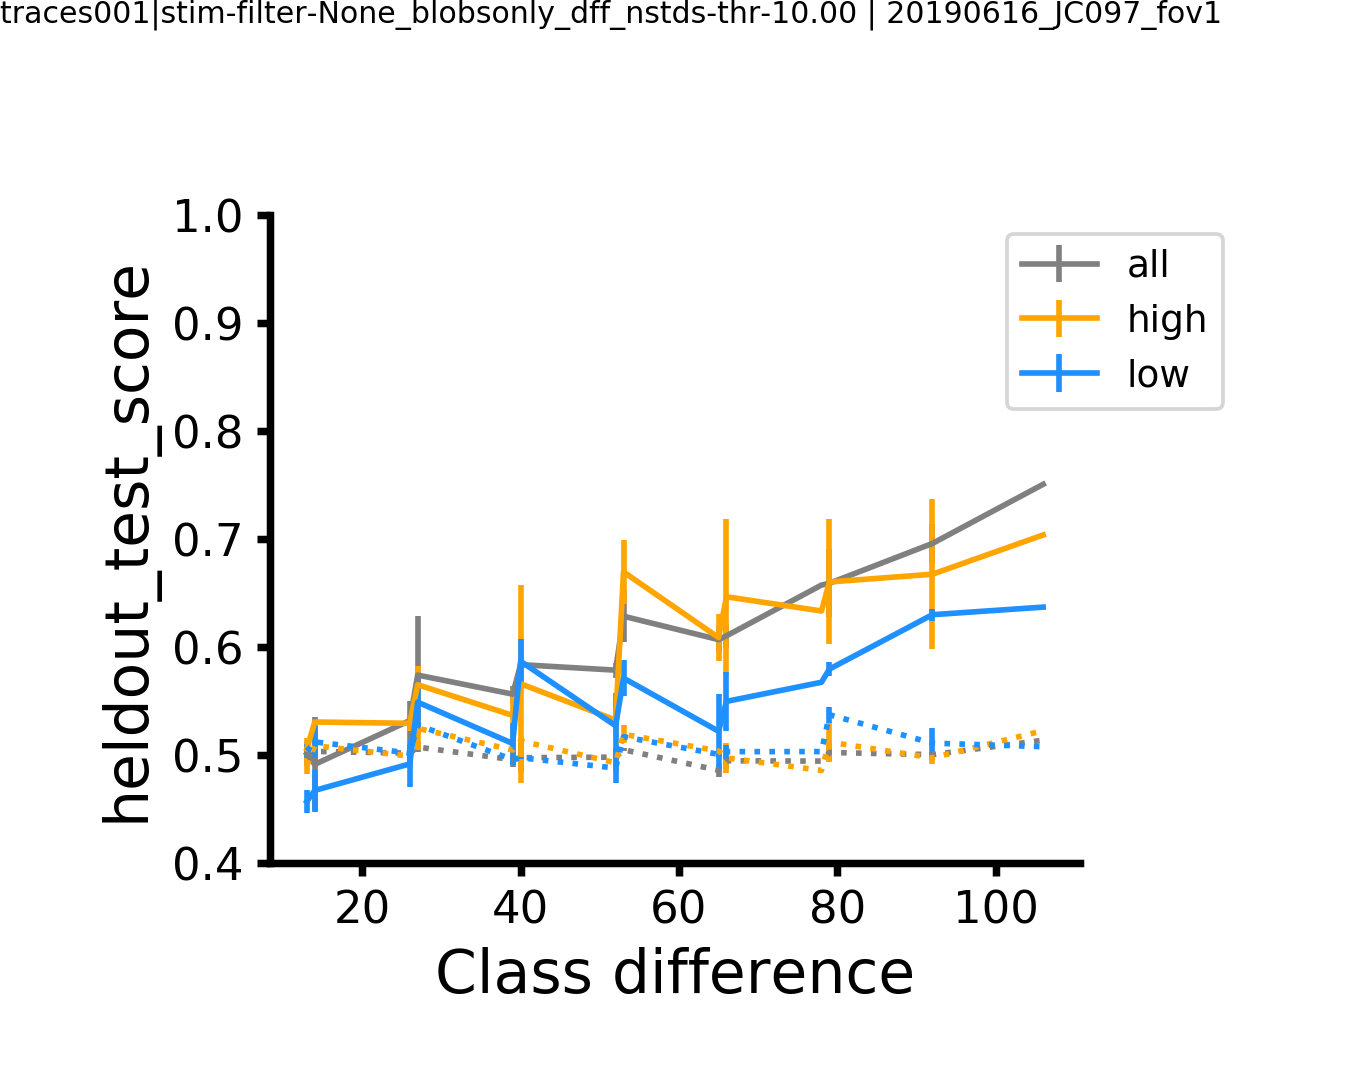

('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding', 'heldout_test_score_by_class_diff_ex-20190616_JC097_fov1_split-colors')


In [153]:
report_metric='heldout_test_score'

fig, ax = pl.subplots(sharex=True, sharey=True, figsize=(5,4), dpi=dpi)

arousal_colors=['gray', 'orange', 'dodgerblue']

for col, (arousal, ag) in zip(arousal_colors, df.groupby(['arousal'])):
    xx = ag.groupby(['class_diff']).mean()[report_metric].index.tolist()
    yy = ag.groupby(['class_diff']).mean()[report_metric].values
    sem_yy = ag.groupby(['class_diff']).sem()[report_metric].values
    ax.errorbar(xx, yy, yerr=sem_yy, color=col, label=arousal)
    
    ch = df_chance[df_chance['arousal']==arousal]
    yy = ch.groupby(['class_diff']).mean()[report_metric].values
    xx = ch.groupby(['class_diff']).mean()[report_metric].index.tolist()
    sem_yy = ch.groupby(['class_diff']).sem()[report_metric].values
    ax.errorbar(xx, yy, yerr=sem_yy, color=col, ls=':', label=None)
    
ax.set_xlabel('Class difference')
ax.set_ylabel(report_metric)

ax.set_ylim([0.4, 1])
ax.legend(bbox_to_anchor=(1.2, 1))
putils.label_figure(fig, '%s | %s' % (data_id, datakey))
pl.subplots_adjust(left=0.2, bottom=0.2, top=0.8, right=0.8)
sns.despine()

figname = '%s_by_class_diff_ex-%s_split-colors' % (report_metric, datakey)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
print(decoding_dir, figname)

In [209]:
decoding_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding'

In [260]:
# # Calculate face feature
# # ----------------------------------------------------------
# face_feature = 'pupil_area'
# #------------------------------------------------------------

# for dkey in curr_dsets['datakey'].unique():

#     print("[%s] getting extracted feature: %s" % (dkey, face_feature))
#     session, animalid, fov = dkey.split('_')
#     fovnum = int(fov[3:])
#     fov = 'FOV%i_zoom2p0x' % fovnum

#     #### Get labels
#     labels_dfile = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_*%s*' % experiment, 'traces',
#                           '%s*' % traceid, 'data_arrays', 'labels.npz'))[0]
#     l = np.load(labels_dfile)
#     labels = pd.DataFrame(data=l['labels_data'], columns=l['labels_columns'])

#     #### Load pupil data
#     facemeta, pupildata = dlcutils.load_pose_data(animalid, session, fovnum, experiment, dlc_results_dir, 
#                                                   feature_list=[face_feature], epoch='trial_alignment', 
#                                                   pre_ITI_ms=iti_pre_ms, post_ITI_ms=iti_post_ms)

#     #### Parse pupil data into traces
#     pupiltraces = dlcutils.get_pose_traces(facemeta, pupildata, labels, feature=face_feature)

#     #### Add to dict
#     datakey ='%s_%s_fov%i_%s' % (session, animalid, fovnum, experiment)  
#     PUPIL[datakey] = pupiltraces


# # This is a dict, keys are datakeys
# with open(pupil_fpath, 'wb') as f:
#     pkl.dump(PUPIL, f, protocol=pkl.HIGHEST_PROTOCOL)


[20190502_JC076_fov1] getting extracted feature: pupil_area
Loading pose data (dlc)
('[blobs] Found runs:', ['1', '2', '3', '4', '5', '6'])
... finding movies for dset: 20190502_JC076_fov1_blobs
(0, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f1_20190502161157200591')
(1, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f2_20190502165806929905')
(2, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f3_20190502173703971093')
(3, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f4_20190502182003125103')
(4, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f4b_20190502183313065375')
(5, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f4b_20190502183351360255')
(6, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f4c_20190502183919522127')
(7, '/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f6_20190502195321083042')
----- File 1.-----
... Eyetracker dir: 20190502_JC076_fov1_blobs_f1_201905

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/dlc_utils.py", line 391, in align_trials_to_facedata
    curr_face_srcdir = [s for s in facetracker_srcdirs if '_f%s_' % run_num in s][0]
IndexError: list index out of range


Getting pose metrics by trial
... found 3 DLC outfiles, expecting 8 based on found eyetracker dirs.
...curr run: 1 [20190502_JC076_fov1_blobs_f1DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
...curr run: 2 [20190502_JC076_fov1_blobs_f2DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
...curr run: 3 [20190502_JC076_fov1_blobs_f3DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
... done parsing!
Parsing pose data with MW
Missing 625 trials total
[20190605_JC090_fov1] getting extracted feature: pupil_area
Loading pose data (dlc)
('[blobs] Found runs:', ['1', '2', '3', '4', '5', '6', '7'])
... finding movies for dset: 20190605_JC090_fov1_blobs
(0, '/n/coxfs01/2p-data/eyetracker_tmp/20190605_JC090_fov1_blobs_f1_20190605141933120131')
(1, '/n/coxfs01/2p-data/eyetracker_tmp/20190605_JC090_fov1_blobs_f2_20190605151304470267')
(2, '/n/coxfs01/2p-data/eyetracker_tmp/20190605_JC090_fov1_blobs_f3_20190605160757630689')
(3, '/n/coxfs01/2p-data/eyetracker_tmp/20190605_JC090_fov1_blobs_f4_20190605

Loading pose data (dlc)
('[blobs] Found runs:', ['1', '2', '3', '4', '5', '6'])
... finding movies for dset: 20190609_JC099_fov1_blobs
(0, '/n/coxfs01/2p-data/eyetracker_tmp/20190609_JC099_fov1_blobs_f1_20190609111435073145')
(1, '/n/coxfs01/2p-data/eyetracker_tmp/20190609_JC099_fov1_blobs_f2_20190609120626917118')
(2, '/n/coxfs01/2p-data/eyetracker_tmp/20190609_JC099_fov1_blobs_f3_20190609131907762511')
(3, '/n/coxfs01/2p-data/eyetracker_tmp/20190609_JC099_fov1_blobs_f4_20190609142912202443')
(4, '/n/coxfs01/2p-data/eyetracker_tmp/20190609_JC099_fov1_blobs_f5_20190609154127271261')
(5, '/n/coxfs01/2p-data/eyetracker_tmp/20190609_JC099_fov1_blobs_f6_20190609155730800664')
----- File 1.-----
... Eyetracker dir: 20190609_JC099_fov1_blobs_f1_20190609111435073145
... found 2 funky frame chunks: [8879, 12579]
... Full run duration: 14.10 min
----- File 2.-----
... Eyetracker dir: 20190609_JC099_fov1_blobs_f2_20190609120626917118
... found 5 funky frame chunks: [3959, 10439, 13475, 15059, 15

...curr run: 10 [20191018_JC113_fov1_blobs_f10DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
...curr run: 11 [20191018_JC113_fov1_blobs_f11DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
...curr run: 12 [20191018_JC113_fov1_blobs_f12DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
... done parsing!
Parsing pose data with MW
Missing 0 trials total
[20191105_JC117_fov1] getting extracted feature: pupil_area
Loading pose data (dlc)
('[blobs] Found runs:', ['1', '2', '3', '4', '5', '6'])
... finding movies for dset: 20191105_JC117_fov1_blobs
(0, '/n/coxfs01/2p-data/eyetracker_tmp/20191105_JC117_fov1_blobs_f1_20191105114840149566')
(1, '/n/coxfs01/2p-data/eyetracker_tmp/20191105_JC117_fov1_blobs_f2_20191105120405410749')
(2, '/n/coxfs01/2p-data/eyetracker_tmp/20191105_JC117_fov1_blobs_f3_20191105132317902204')
(3, '/n/coxfs01/2p-data/eyetracker_tmp/20191105_JC117_fov1_blobs_f4_20191105134239875931')
(4, '/n/coxfs01/2p-data/eyetracker_tmp/20191105_JC117_fov1_blobs_f5_201911051430137572

# Decode

In [23]:
#### Load neural responses
trial_epoch='stimulus'
responsive_test='None' #'roc'
responsive_thr=0.05
response_type='dff'

#### Check for equal trial counts
edata, cells, MEANS = aggr.get_source_data(experiment, equalize_now=True, response_type=response_type,
                                      responsive_test=responsive_test, responsive_thr=responsive_thr, 
                                      trial_epoch=trial_epoch) 
cells.groupby(['visual_area']).count()

...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_None-thr-0.05_dff_stimulus.pkl
---equalizing now---
Segmentation, missing:
20190502_JC076_fov1
20191008_JC091_fov1


,cell,fov,animalid,session,datakey,fovnum
visual_area,,,,,,
Li,1814,1814,1814,1814,1814,1814
Ll,95,95,95,95,95,95
Lm,3179,3179,3179,3179,3179,3179
V1,3385,3385,3385,3385,3385,3385


In [24]:
iti_pre=1
stim_dur=1
A = aggr.aggregate_alignment_info(edata)
aligned_keys = A[(A['iti_pre']==iti_pre) & (A['stim_dur']==stim_dur)]['datakey'].unique()
len(aligned_keys)

Realign: 20190420_JC076_fov1


36

In [20]:
#### Get labels
animalid = 'JC084'
session = '20190522'
fov = 'FOV1_zoom2p0x'
rootdir = '/n/coxfs01/2p-data'
labels_dfile = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_*%s*' % experiment, 'traces',
                      '%s*' % traceid, 'data_arrays', 'labels.npz'))[0]
l = np.load(labels_dfile)
labels = pd.DataFrame(data=l['labels_data'], columns=l['labels_columns'])

In [34]:
face_feature='pupil_fraction'
feature_name='pupil_area'
alignment_type='trial'
# Pupil -------------------------------------------
pupil_feature='pupil_fraction'
pupil_epoch='pre'
pupil_snapshot=391800
redo_pupil=False
pupil_framerate=20.
# -------------------------------------------------

pupil_epoch='pre'
face_framerate=20.
desired_nframes = 60 #len(out_ixs) # 60

# Temporal binning params
face_framerate = 20.0
framerate = 44.65

#### Get trial epochs
stim_on = float(labels['stim_on_frame'].unique())
n_on = float(labels['nframes_on'].unique())
iti_pre = float(A['iti_pre'].unique())
iti_post = float(A['iti_post'].unique())
stim_dur = stim_on/framerate
new_stim_on = (iti_pre)*face_framerate #int(np.where(abs(out_ixs-stim_on) == min(abs(out_ixs-stim_on)))[0])
desired_nframes = int( (stim_dur + iti_pre + iti_post)*face_framerate)
print("Stim on (new fr): %i" % new_stim_on)


Stim on (new fr): 20


In [35]:
from pipeline.python.eyetracker import dlc_utils as dlcutils

In [41]:
reload(dlcutils)

<module 'pipeline.python.eyetracker.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/eyetracker/dlc_utils.py'>

In [43]:
#### Get pupil responses
#if 'pupil' in analysis_type:
pupildata = dlcutils.get_aggregate_pupildfs(experiment=experiment, 
                                        feature_name=feature_name, 
                                        alignment_type=alignment_type,
                                        trial_epoch=pupil_epoch,
                                        iti_pre=iti_pre, iti_post=iti_post, stim_dur=stim_dur,
                                        in_rate=face_framerate, out_rate=face_framerate,
                                        snapshot=pupil_snapshot, create_new=redo_pupil)

~~~~~ Aggregating pupil traces. ~~~~~~
Aggregated pupil traces. Missing 2 datasets.
20190422_JC076_fov1
20191008_JC091_fov1
~~~~~~~~~~~~ Aggregating pupil dataframes. ~~~~~~~~~~~
---> Saved aggr dataframes: /n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/metrics_blobs_pupil_area_pre_snapshot-391800.pkl


In [38]:
datakey='20190616_JC097_fov1'
pupildata[datakey].shape

KeyError: '20190616_JC097_fov1'

In [40]:
pupiltraces.keys()

NameError: name 'pupiltraces' is not defined

# decode at 1 c

In [37]:
segmented_datasets = cells['datakey'].unique()

In [57]:
use_quartiles = False
n_cuts = 4 if use_quartiles else 3
min_ncells = 5

# Classifier params
m0=0
m100=106
C_value=1

cv_nfolds=5
test_size=0.2
n_iterations = 50
report_metric = 'heldout_test_score'
skip = [] # ['20190502_JC076_fov1'] # ['20190420_JC076_fov1']

need_to_segment=[]
need_to_realign=[]

d_list=[]; d_list_chance=[]; 
n_datakeys = len(dsets['datakey'].unique())
for di, ((visual_area, datakey), ds) in enumerate(dsets.groupby(['visual_area', 'datakey'])):
    if datakey not in segmented_datasets:
        need_to_segment.append(datakey)
        continue
    if datakey not in aligned_keys:
        need_to_realign.append(datakey)
        continue
        
    if di % 5 == 0:
        print("%i of %i datakeys" % (int(di+1), n_datakeys))
        
    print("----- %s | %s -----" % (visual_area, datakey))
    # ------ STIMULUS INFO -----------------------------------------
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
    sdf = obj.get_stimuli()
    
    #### Get neural means
    neuraldf = aggr.get_neuraldf_for_cells_in_area(cells, MEANS, 
                                                   datakey=datakey, visual_area=visual_area) # MEANS[datakey].copy() 
    print("... n=%i cells" % int(neuraldf.shape[1]-1))
    if neuraldf.shape[1]<min_ncells:
        continue
        
    #### Get pupil means
    pupildf = pupildata[datakey].copy()
    
    #### Filter out trials with no pupil info or no neural
    neuraldf, pupildf = dlcutils.match_trials_df(neuraldf, pupildf)
    
    # ------ Split trials by quantiles ---------------------------------
    pupil_low, pupil_high = dlcutils.split_pupil_range(pupildf, feature_name=face_feature, n_cuts=n_cuts)

    # Get trial indices of low/high pupil 
    low_trial_ixs = pupil_low['trial'].unique()
    high_trial_ixs = pupil_high['trial'].unique()
    all_trial_ixs = pupildf['trial'].unique()
    
    # Fit ALL
    tmp_d_list=[]; tmp_shuf_list=[];
    i=0
    for arousal, curr_trial_ixs in zip(['all', 'low', 'high'], [all_trial_ixs, low_trial_ixs, high_trial_ixs]):
        curr_data = neuraldf.loc[curr_trial_ixs].copy()
        iterdict, iterdict_chance = fit_classifier_bootstrap(curr_data, sdf, m0=m0, m100=m100, 
                                      n_iterations=n_iterations,
                                      cv_nfolds=cv_nfolds, test_size=test_size, C_value=C_value)
        iterdict['arousal'] = arousal
        iterdict_chance['arousal'] = arousal
        
        tmp_d_list.append(pd.DataFrame(iterdict, index=[i])) #df)
        tmp_shuf_list.append(pd.DataFrame(iterdict_chance, index=[i])) #df_chance)
        print("...%s: %.2f (chance=%.2f)" % (arousal, iterdict[report_metric], iterdict_chance[report_metric]))
        
        i+=1
        
    tmp_df = pd.concat(tmp_d_list, axis=0)
    metadict = {'visual_area': visual_area, 'datakey': datakey, 'n_cells': int(neuraldf.shape[1]-1)}
    tmp_df = putils.add_meta_to_df(tmp_df, metadict)
    # print(tmp_df.shape)
    tmp_chance = pd.concat(tmp_shuf_list, axis=0)
    tmp_chance = putils.add_meta_to_df(tmp_chance, metadict)
    
    d_list.append(tmp_df)
    d_list_chance.append(tmp_chance)

df = pd.concat(d_list, axis=0)
df_chance = pd.concat(d_list_chance, axis=0)

1 of 35 datakeys
----- Li | 20190502_JC076_fov1 -----
... n=0 cells
----- Li | 20190602_JC091_fov1 -----
... n=136 cells
...all: 0.72 (chance=0.50)
...low: 0.68 (chance=0.49)
...high: 0.69 (chance=0.47)
----- Li | 20190606_JC091_fov1 -----
... n=82 cells
...all: 0.57 (chance=0.50)
...low: 0.54 (chance=0.48)
...high: 0.51 (chance=0.50)
----- Li | 20190607_JC091_fov1 -----
... n=129 cells
...all: 0.56 (chance=0.51)
...low: 0.61 (chance=0.52)
...high: 0.50 (chance=0.49)
6 of 35 datakeys
----- Li | 20190609_JC099_fov1 -----
... n=71 cells
...all: 0.62 (chance=0.51)
...low: 0.59 (chance=0.49)
...high: 0.65 (chance=0.50)
----- Li | 20190612_JC099_fov1 -----
... n=49 cells
...all: 0.51 (chance=0.50)
...low: 0.45 (chance=0.49)
...high: 0.50 (chance=0.49)
----- Li | 20190614_JC091_fov1 -----
... n=129 cells
...all: 0.62 (chance=0.51)
...low: 0.62 (chance=0.50)
...high: 0.48 (chance=0.49)
----- Li | 20190617_JC099_fov1 -----
... n=20 cells
...all: 0.57 (chance=0.51)
...low: 0.50 (chance=0.50)
..

In [116]:
df[df['datakey']=='20190616_JC097_fov1']

,C,C_sem,C_std,arousal,class_a,class_b,fit_time,fit_time_sem,fit_time_std,heldout_MI,...,score_time_sem,score_time_std,test_score,test_score_sem,test_score_std,train_score,train_score_sem,train_score_std,datakey,visual_area
0,1.0,0.0,0.0,all,0,106,0.013513,0.000049,0.000347,0.136039,...,0.000010,0.000070,0.736204,0.003559,0.025164,1.0,0.0,0.0,20190616_JC097_fov1,V1
1,1.0,0.0,0.0,low,0,106,0.001978,0.000009,0.000066,0.094974,...,0.000003,0.000018,0.688315,0.006898,0.048773,1.0,0.0,0.0,20190616_JC097_fov1,V1
2,1.0,0.0,0.0,high,0,106,0.001801,0.000005,0.000032,0.097886,...,0.000001,0.000010,0.650788,0.006978,0.049340,1.0,0.0,0.0,20190616_JC097_fov1,V1


In [58]:
min_ncells=20

too_few_cells = df[df['n_cells']<min_ncells]['datakey'].unique()
print(too_few_cells)

['20191111_JC120_fov1']


In [59]:
df_chance.columns

Index([u'arousal', u'class_a', u'class_b', u'fit_time', u'fit_time_sem',
       u'fit_time_std', u'heldout_MI', u'heldout_MI_sem', u'heldout_MI_std',
       u'heldout_aMI', u'heldout_aMI_sem', u'heldout_aMI_std',
       u'heldout_log2MI', u'heldout_log2MI_sem', u'heldout_log2MI_std',
       u'heldout_test_score', u'heldout_test_score_sem',
       u'heldout_test_score_std', u'score_time', u'score_time_sem',
       u'score_time_std', u'test_score', u'test_score_sem', u'test_score_std',
       u'train_score', u'train_score_sem', u'train_score_std', u'datakey',
       u'visual_area', u'n_cells'],
      dtype='object')

In [60]:
avg_test = df.groupby(['visual_area', 'datakey']).mean()['test_score'].reset_index()

avg_test_chance = df_chance.groupby(['visual_area', 'datakey']).mean()['test_score'].reset_index()
avg_test_chance.rename(columns={'test_score': 'chance_score'}, inplace=True)


avg_results = pd.merge(avg_test, avg_test_chance)

In [61]:
poor_performance = [dk for (v, dk), g in avg_results.groupby(['visual_area', 'datakey'])\
                        if g['test_score'].values<g['chance_score'].values 
                           or g['test_score'].values < 0.5]
print(poor_performance)

['20190612_JC099_fov1', '20191018_JC113_fov1']


In [62]:
dst_dir = os.path.join(decoding_dir, 'pupil', 'by_fov')
if not os.path.exists(dst_dir):
    print(dst_dir)
    os.makedirs(dst_dir)

<IPython.core.display.Javascript object>


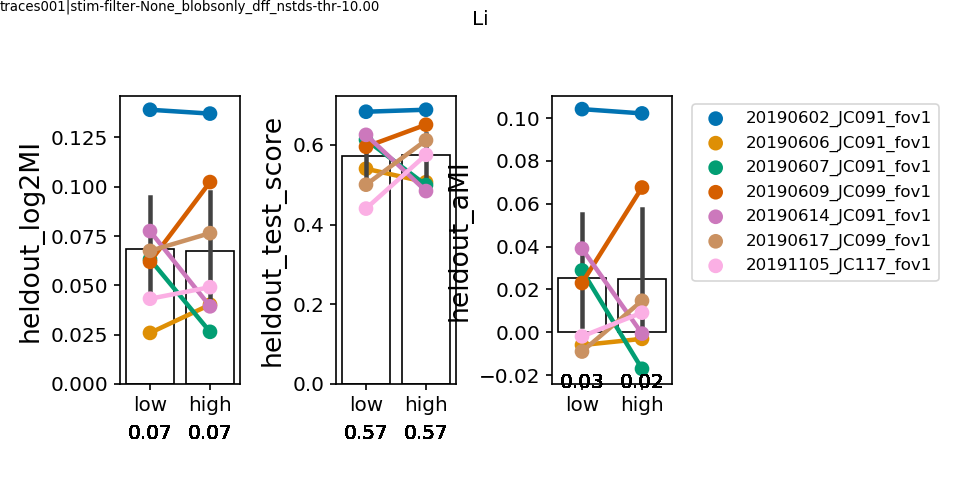

STATS - Li
heldout_log2MI--------------------
Paired t-test, t=0.10 (p=0.92)
heldout_test_score--------------------
Paired t-test, t=-0.07 (p=0.95)
heldout_aMI--------------------
Paired t-test, t=0.06 (p=0.95)
('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding/pupil/by_fov', '_pupil_fraction_Li_morph0v106_C-1.00_50-iters_oldway')


<IPython.core.display.Javascript object>


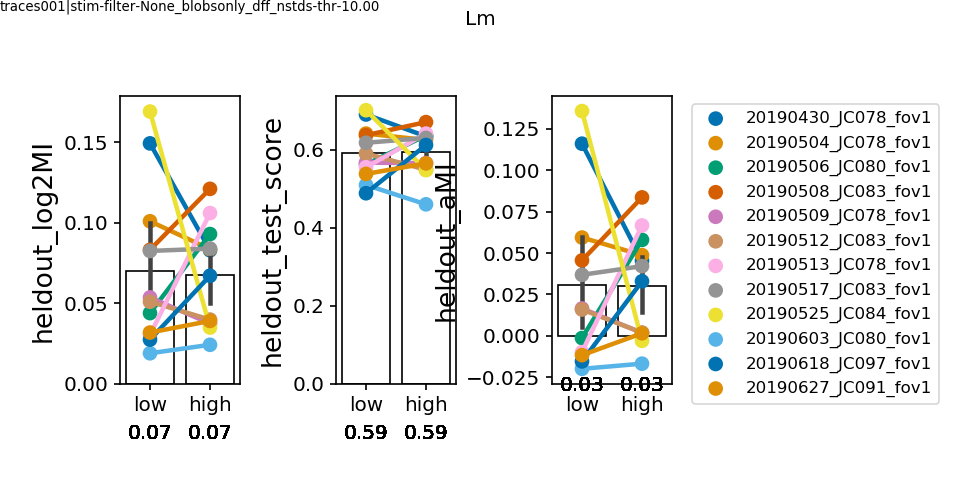

STATS - Lm
heldout_log2MI--------------------
Paired t-test, t=0.15 (p=0.88)
heldout_test_score--------------------
Paired t-test, t=-0.15 (p=0.88)
heldout_aMI--------------------
Paired t-test, t=0.02 (p=0.98)
('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding/pupil/by_fov', '_pupil_fraction_Lm_morph0v106_C-1.00_50-iters_oldway')


<IPython.core.display.Javascript object>


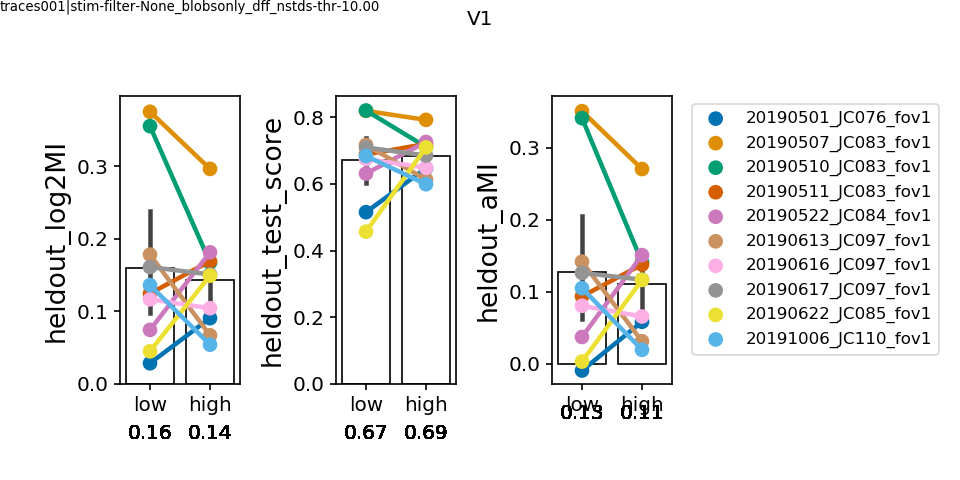

STATS - V1
heldout_log2MI--------------------
Paired t-test, t=0.53 (p=0.61)
heldout_test_score--------------------
Paired t-test, t=-0.37 (p=0.72)
heldout_aMI--------------------
Paired t-test, t=0.50 (p=0.63)
('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding/pupil/by_fov', '_pupil_fraction_V1_morph0v106_C-1.00_50-iters_oldway')


In [63]:


skip = list(too_few_cells)
skip.extend(poor_performance) #['20190602_JC091_fov1', '20191105_JC117_fov1', '20191111_JC120_fov1']#'20190602_JC091_fov1', '20190502_JC076_fov1'

for visual_area, vdf in df.groupby(['visual_area']):

    plotdf = vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
    metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

    fig, axn = pl.subplots(1, 3, figsize=(8,4), dpi=dpi)
    fig.patch.set_alpha(1)
    
    for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

        # Plot each fov
        sns.pointplot(x='arousal', y=metric, hue='datakey', data=plotdf, ax=ax, 
                      palette='colorblind', s=10, alpha=0.5)
        sns.barplot(x='arousal', y=metric, data=plotdf, ax=ax, 
                    edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
        plotdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))
        if ai<2:
            ax.legend_.remove()
        ax.set_xlabel('')

    ax.legend(bbox_to_anchor=(1.1, 1))
    pl.subplots_adjust(right=0.7, wspace=0.8, hspace=0.2, top=0.8, bottom=0.2)
    fig.suptitle(visual_area)
    
    #
    print("STATS - %s" % visual_area)
    metric = 'heldout_test_score'
    for metric in metrics:
        print('%s--------------------' % metric)
        a = plotdf[(plotdf['arousal']=='low')][metric]
        b = plotdf[(plotdf['arousal']=='high')][metric]
        tstat, pval = spstats.ttest_rel(a, b)
        print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

    putils.label_figure(fig, data_id)
    C_str = 'C-%.2f' % C_value if C_value is not None else 'tuneC'
    figname = '_%s_%s_morph%iv%i_%s_%i-iters_oldway' % (face_feature, visual_area, m0, m100, C_str, n_iterations)
    pl.savefig(os.path.join(dst_dir, '%s.svg' %figname))
    print(dst_dir, figname)

In [ ]:
skip = ['20190602_JC091_fov1', '20191105_JC117_fov1', '20191111_JC120_fov1']#'20190602_JC091_fov1', '20190502_JC076_fov1'

for visual_area, vdf in df.groupby(['visual_area']):

    plotdf = vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
    metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

    fig, axn = pl.subplots(1, 3, figsize=(10,4), dpi=dpi)
    for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

        # Plot each fov
        sns.pointplot(x='arousal', y=metric, hue='datakey', data=plotdf, ax=ax, 
                      palette='colorblind', s=10, alpha=0.5)
        sns.barplot(x='arousal', y=metric, data=plotdf, ax=ax, 
                    edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
        plotdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))
        if ai<2:
            ax.legend_.remove()
        ax.set_xlabel('')

    ax.legend(bbox_to_anchor=(1.1, 1))
    pl.subplots_adjust(right=0.7, wspace=0.8, hspace=0.2, top=0.8, bottom=0.2)
    fig.suptitle(visual_area)
    
    #
    print("STATS - %s" % visual_area)
    metric = 'heldout_test_score'
    for metric in metrics:
        print('%s--------------------' % metric)
        a = plotdf[(plotdf['arousal']=='low')][metric]
        b = plotdf[(plotdf['arousal']=='high')][metric]
        tstat, pval = spstats.ttest_rel(a, b)
        print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

    putils.label_figure(fig, data_id)
    figname = '%s_%s-test_%iv%i_C-%.2f, %i-iters' % (face_feature, visual_area, m0, m100, C_value, n_iterations)
    #pl.savefig(os.path.join(decoding_dir, '%s.svg' %figname))


In [113]:

metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = plotdf[(plotdf['arousal']=='low')][metric]
    b = plotdf[(plotdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

heldout_log2MI--------------------
Paired t-test, t=1.42 (p=0.21)
heldout_test_score--------------------
Paired t-test, t=3.57 (p=0.02)
heldout_aMI--------------------
Paired t-test, t=1.98 (p=0.10)


In [97]:
tstats, pval = spstats.ttest_rel(a, b)

In [108]:
cell_counts = pd.concat([pd.DataFrame({'visual_area':visual_area, 
                                       'datakey': datakey, 
                                       'n_cells': len(g['cell'])}, index=[i]) \
                    for i, ((visual_area, datakey), g) in enumerate(cells.groupby(['visual_area', 'datakey']))], axis=0)
cell_counts

,datakey,n_cells,visual_area
0,20190602_JC091_fov1,136,Li
1,20190606_JC091_fov1,82,Li
2,20190607_JC091_fov1,129,Li
3,20190609_JC099_fov1,71,Li
4,20190612_JC099_fov1,49,Li
5,20190614_JC091_fov1,129,Li
6,20190617_JC099_fov1,20,Li
7,20191105_JC117_fov1,60,Li
8,20191111_JC120_fov1,19,Li
9,20190603_JC080_fov1,190,Lm


In [105]:
cell_counts = pd.concat([pd.DataFrame({'visual_area':visual_area, 
                                       'datakey': datakey, 
                                       'n_cells': MEANS[datakey].shape[1]-1}, index=[i]) \
                    for i, ((visual_area, datakey), g) in enumerate(dsets.groupby(['visual_area', 'datakey']))], axis=0)
cell_counts

,datakey,n_cells,visual_area
0,20190502_JC076_fov1,150,Li
1,20190602_JC091_fov1,241,Li
2,20190605_JC090_fov1,129,Li
3,20190606_JC091_fov1,136,Li
4,20190607_JC091_fov1,260,Li
5,20190609_JC099_fov1,78,Li
6,20190612_JC099_fov1,95,Li
7,20190614_JC091_fov1,193,Li
8,20190617_JC099_fov1,25,Li
9,20191018_JC113_fov1,64,Li


In [108]:
decoding_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding'

<IPython.core.display.Javascript object>


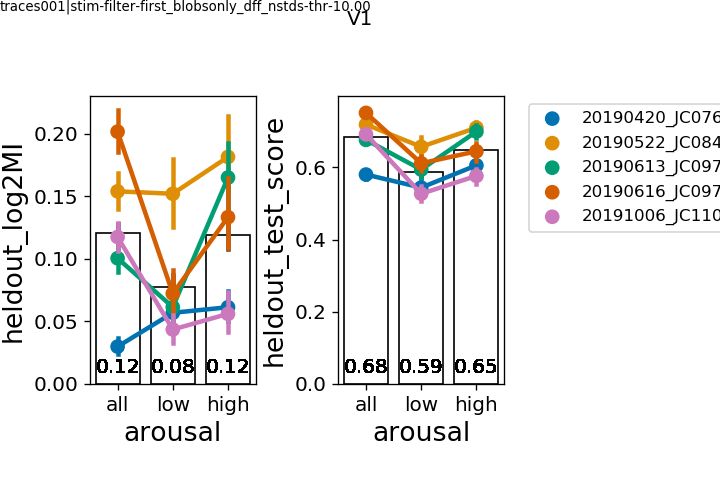

In [277]:
visual_area='V1'
if visual_area == 'V1':
    skip = ['20190507_JC083_fov1', '20190617_JC097_fov1', '20190622_JC085_fov1'] # fix eyetracker
elif visual_area == 'Li':
    skip = ['20190602_JC091_fov1', '20191018_JC113_fov1']
else:
    skip = []

plotdf = df[~df['datakey'].isin(skip)]

fig, axn = pl.subplots(1, 2, figsize=(6,4), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, ['heldout_log2MI', 'heldout_test_score'])):


    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=plotdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)
    sns.barplot(x='arousal', y=metric, data=plotdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    if ai==0:
        ax.legend_.remove()
        
ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(right=0.7, wspace=0.5, hspace=0.2, top=0.8, bottom=0.2)
fig.suptitle(visual_area)

putils.label_figure(fig, data_id)

figname = 'split_%s_%s-test_classify_%iv%i_C-%.2f, %i-iters' % (face_feature, visual_area, m0, m100, C_value, n_iterations)
pl.savefig(os.path.join(decoding_dir, '%s.svg' %figname))


#### snapshot 1

In [162]:
skip = ['20190420_JC076_fov1', '20190507_JC083_fov1', '20190617_JC097_fov1']

fig, axn = pl.subplots(1, 2, figsize=(12,4), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, ['heldout_aMI', 'heldout_test_score'])):

    # Create dataframe
    m_ = pd.concat([full_df[[metric]], lo_df[metric], hi_df[metric]], axis=1)
    m_.columns = ['all', 'low', 'high']
    m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})
    m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
    m_df = m_df[~m_df['datakey'].isin(skip)]
    
    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)
    sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    if ai==0:
        ax.legend_.remove()
        
ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(right=0.5, wspace=0.5, hspace=0.2, top=0.8, bottom=0.2)


figname = 'split_%s_%s-test_classify_%iv%i_C-%.2f, %i-iters' % (face_feature, visual_area, m0, m100, C_value, n_iterations)
pl.savefig(os.path.join(decoding_dir, '%s.svg' %figname))


<IPython.core.display.Javascript object>

NameError: name 'full_df' is not defined

#### snapshot 2

<IPython.core.display.Javascript object>


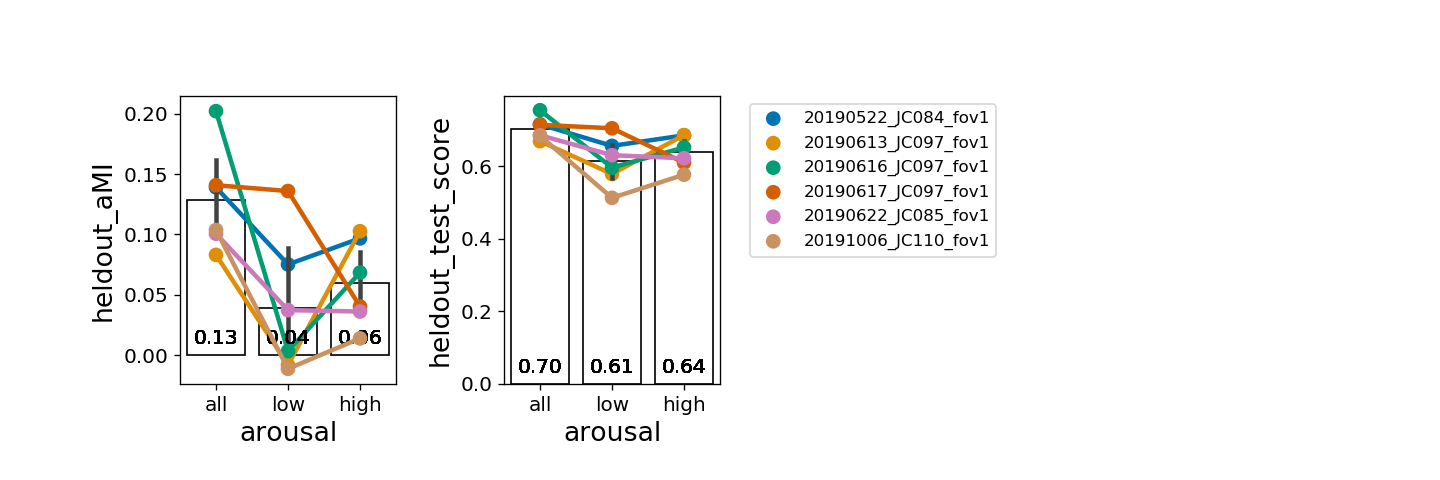

In [202]:
skip = ['20190420_JC076_fov1', '20190507_JC083_fov1']

fig, axn = pl.subplots(1, 2, figsize=(12,4), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, ['heldout_aMI', 'heldout_test_score'])):

    # Create dataframe
    m_ = pd.concat([full_df[[metric]], lo_df[metric], hi_df[metric]], axis=1)
    m_.columns = ['all', 'low', 'high']
    m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})
    m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
    m_df = m_df[~m_df['datakey'].isin(skip)]
    
    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)
    sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    if ai==0:
        ax.legend_.remove()
        
ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(right=0.5, wspace=0.5, hspace=0.2, top=0.8, bottom=0.2)

<IPython.core.display.Javascript object>


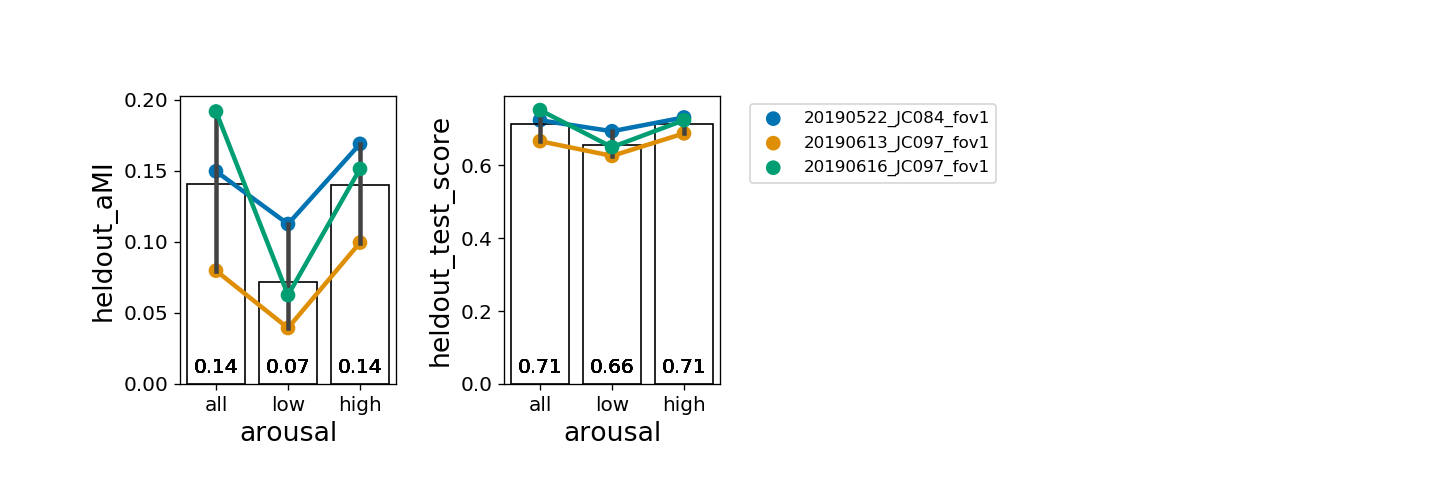

In [80]:
skip = ['20190420_JC076_fov1', '20190507_JC083_fov1']

fig, axn = pl.subplots(1, 2, figsize=(12,4), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, ['heldout_aMI', 'heldout_test_score'])):

    # Create dataframe
    m_ = pd.concat([full_df[[metric]], lo_df[metric], hi_df[metric]], axis=1)
    m_.columns = ['all', 'low', 'high']
    m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})
    m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
    m_df = m_df[~m_df['datakey'].isin(skip)]
    
    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, 
                  palette='colorblind', s=10)
    sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    if ai==0:
        ax.legend_.remove()
        
ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(right=0.5, wspace=0.5, hspace=0.2, top=0.8, bottom=0.2)

<IPython.core.display.Javascript object>


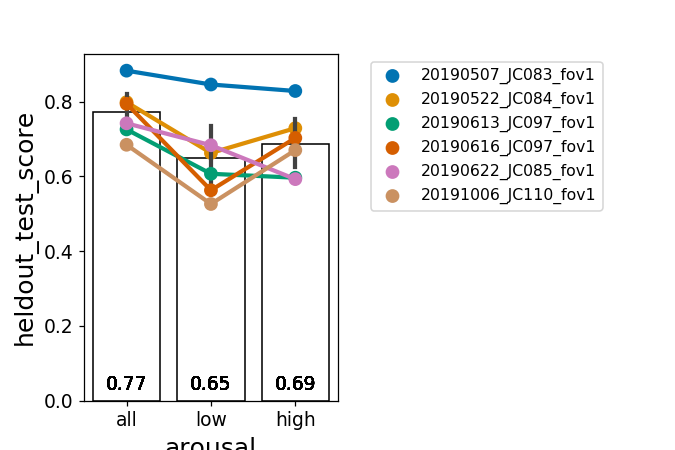

In [305]:
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, palette='colorblind',
             s=10)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
ax.legend(bbox_to_anchor=(1.1, 1))

pl.subplots_adjust(right=0.5)

In [124]:
# multi_comp_test='fdr_bh'
# # Annotate w stats
# print("********* [%s|%s] *********" % (experiment, metric))
# #y_loc = 16 if fov_means else 23
# statresults = aggr.do_mannwhitney(m_df, metric=metric, multi_comp_test=multi_comp_test)
# aggr.annotate_stats_areas(statresults, ax) #, y_loc=y_loc, offset=1)


# All areas

In [238]:
report_metric = 'heldout_test_score'
m0=0
m100=106
C_value=1
n_iterations = 100
skip = [] # ['20190502_JC076_fov1'] # ['20190420_JC076_fov1']
use_quartiles = True

d_list=[]; d_list_chance=[]; 
n_datakeys = len(dsets['datakey'].unique())
for di, ((visual_area, datakey), ds) in enumerate(dsets.groupby(['visual_area', 'datakey'])):
    if datakey in skip:
        continue
    if di % 5 == 0:
        print("%i of %i datakeys" % (int(di+1), n_datakeys))
        
    print("----- %s -----" % datakey)
    neuraldf = MEANS[datakey].copy() 
    
    # ------ STIMULUS INFO -----------------------------------------
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
    sdf = obj.get_stimuli()
    
    # ------ PUPIL --------------------------------------------------
    ptraces = pupiltraces['%s_%s' % (datakey, experiment)].copy()

    #### Resample pupil
    desired_nframes = 60 #len(out_ixs) # 60
    binned_pupil = bin_pupil_traces(pupiltraces, feature_name=face_feature,
                                         in_rate=20.0, out_rate=new_framerate, 
                                         min_nframes=desired_nframes)
    trials_ = sorted(pupiltraces['trial'].unique())
    frames_ = np.arange(0, desired_nframes)
    pupil_trialmat = pd.DataFrame(np.vstack([p[face_feature].values for trial, p in binned_pupil.groupby(['trial'])]),
                                  index=trials_, columns=frames_)
    pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
    pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
    
    # ------ Split trials by quantiles ---------------------------------
    if use_quartiles:
        pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])
        low_pupil_thr = pupil_quantiles[0.25]
        high_pupil_thr = pupil_quantiles[0.75]
        pupil_low = pupildf[pupildf['pupil']<=low_pupil_thr].copy()
        pupil_high = pupildf[pupildf['pupil']>=high_pupil_thr].copy()
    else:
        pupildf['quantile'] = pd.qcut(pupildf['pupil'], 3, labels=False)
        pupil_low = pupildf[pupildf['quantile']==0].copy()
        pupil_high = pupildf[pupildf['quantile']==2].copy()

    # Get trial indices of low/high pupil 
    low_trial_ixs = pupil_low['trial'].unique()
    high_trial_ixs = pupil_high['trial'].unique()
    all_trial_ixs = pupildf['trial'].unique()
    
    # Fit ALL
    tmp_d_list=[]
    tmp_shuf_list = []
    for arousal, curr_trial_ixs in zip(['all', 'low', 'high'], [all_trial_ixs, low_trial_ixs, high_trial_ixs]):
        curr_data = neuraldf.loc[curr_trial_ixs].copy()
        iterdict, iterdict_chance = fit_classifier_bootstrap(curr_data, sdf, m0=m0, m100=m100, n_iterations=n_iterations,
                                      cv_nfolds=cv_nfolds, test_size=test_size, C_value=C_value)
        iterdict['arousal'] = arousal
        iterdict_chance['arousal'] = arousal
        tmp_d_list.append(pd.DataFrame(iterdict, index=[i])) #df)
        tmp_shuf_list.append(pd.DataFrame(iterdict_chance, index=[i])) #df_chance)
        print("%s: %.2f (chance=%.2f)" % (arousal, iterdict[report_metric], iterdict_chance[report_metric]))

        i+=1
        
    tmp_df = pd.concat(tmp_d_list, axis=0)
    metadict = {'visual_area': visual_area, 'datakey': datakey}
    tmp_df = putils.add_meta_to_df(tmp_df, metadict)
    print(tmp_df.shape)
    tmp_chance = pd.concat(tmp_shuf_list, axis=0)
    tmp_chance = putils.add_meta_to_df(tmp_chance, metadict)
    
    d_list.append(tmp_df)
    d_list_chance.append(tmp_chance)

df = pd.concat(d_list, axis=0)
df_chance = pd.concat(d_list_chance, axis=0)

1 of 35 datakeys
----- 20190502_JC076_fov1 -----
Creating blobs object [JC076|20190502|FOV1_zoom2p0x|traces001]
all: 0.54 (chance=0.50)
low: 0.58 (chance=0.51)
high: 0.55 (chance=0.49)
(3, 41)
----- 20190602_JC091_fov1 -----
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
all: 0.72 (chance=0.49)
low: 0.79 (chance=0.48)
high: 0.72 (chance=0.48)
(3, 41)
----- 20190605_JC090_fov1 -----
Creating blobs object [JC090|20190605|FOV1_zoom2p0x|traces001]
all: 0.53 (chance=0.49)
low: 0.62 (chance=0.50)
high: 0.61 (chance=0.50)
(3, 41)
----- 20190606_JC091_fov1 -----
Creating blobs object [JC091|20190606|FOV1_zoom2p0x|traces001]
all: 0.59 (chance=0.51)
low: 0.62 (chance=0.50)
high: 0.43 (chance=0.49)
(3, 41)
----- 20190607_JC091_fov1 -----
Creating blobs object [JC091|20190607|FOV1_zoom2p0x|traces001]
all: 0.54 (chance=0.50)
low: 0.48 (chance=0.48)
high: 0.47 (chance=0.54)
(3, 41)
6 of 35 datakeys
----- 20190609_JC099_fov1 -----
Creating blobs object [JC099|20190609|FOV1_zoom2p0x|tr

### Get cell counts

In [239]:
cell_counts = pd.concat([pd.DataFrame({'visual_area':visual_area, 
                                       'datakey': datakey, 
                                       'n_cells': MEANS[datakey].shape[1]-1}, index=[i]) \
                    for i, ((visual_area, datakey), g) in enumerate(dsets.groupby(['visual_area', 'datakey']))], axis=0)

### Save data

In [252]:
results_fpath = os.path.join(decoding_dir, 'results.pkl')
params_fpath = os.path.join(decoding_dir, 'params.json')

params = {'m0': m0, 'm100': m100, 'C_value': C_value, 'n_iterations': n_iterations}
results = {'df': df, 'df_chance': df_chance, 'cell_counts': cell_counts}

with open(results_fpath, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)
    
with open(params_fpath, 'w') as f:
    json.dump(params, f, indent=4)
    


In [259]:
min_ncells=50

too_few = cell_counts[cell_counts['n_cells']<min_ncells]['datakey'].unique()
too_few

array(['20190617_JC099_fov1', '20191111_JC120_fov1'], dtype=object)

In [260]:
'20190618_JC097_fov1' in cell_counts['datakey'].unique()


True

<IPython.core.display.Javascript object>


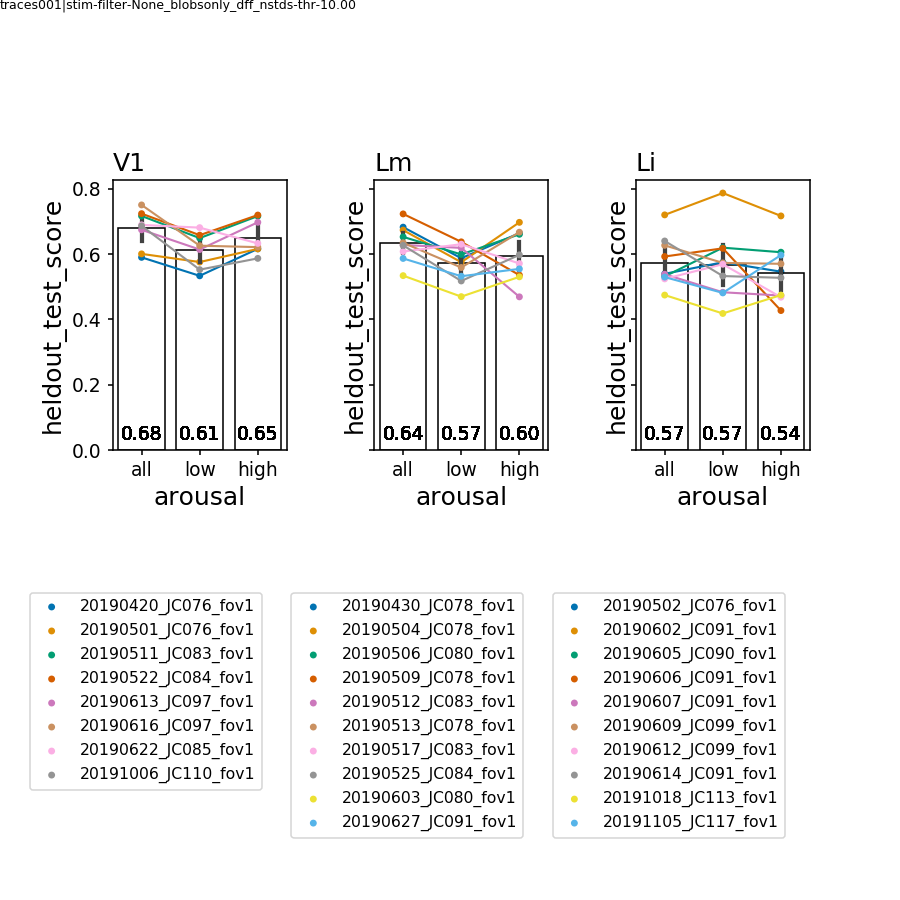

('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding', 'heldout_test_score_pupil_area_by-area_min-50-cells')


In [261]:
#few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']
skip = ['20190507_JC083_fov1', '20190617_JC097_fov1', '20190510_JC083_fov1',
        '20190618_JC097_fov1', '20190508_JC083_fov1']
# skip=[]
skip.extend(too_few)

metric='heldout_test_score'
#metric='heldout_log2MI'

plotdf = df[~df['datakey'].isin(skip)]

ai=0
fig, axn = pl.subplots(1, 3, figsize=(8,8), dpi=dpi, sharex=True, sharey=True)
for ax, (visual_area, a_df) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                     s=10, join=True, scale=0.5)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')

    ax.set_title(visual_area, loc='left', fontsize=16)
    #ax.axhline(y=0.5, color='k', linestyle=':')
    
    ax.legend(bbox_to_anchor=(0.9, -0.5))
    ai+=1
    
pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
#sns.despine(trim=True)

putils.label_figure(fig, data_id)
figname = '%s_%s_by-area_min-%i-cells' % (metric, face_feature, min_ncells)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
print(decoding_dir, figname)

<IPython.core.display.Javascript object>


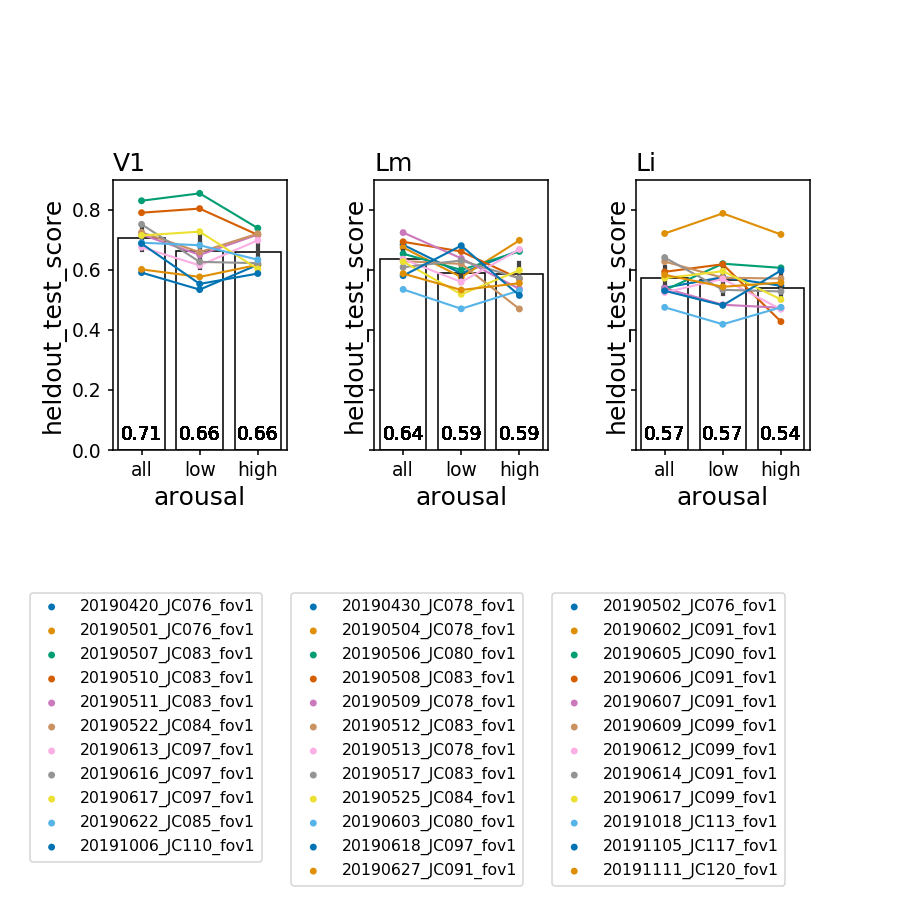

In [245]:
#few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']
# skip = ['20190507_JC083_fov1', '20190617_JC097_fov1',
#         '20190618_JC097_fov1', '20190508_JC083_fov1']
skip=[]
skip.extend(too_few)

metric='heldout_test_score'
#metric='heldout_log2MI'

plotdf = df[~df['datakey'].isin(skip)]

ai=0
fig, axn = pl.subplots(1, 3, figsize=(8,8), dpi=dpi, sharex=True, sharey=True)
for ax, (visual_area, a_df) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                     s=10, join=True, scale=0.5)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')

    ax.set_title(visual_area, loc='left', fontsize=16)
    #ax.axhline(y=0.5, color='k', linestyle=':')
    
    ax.legend(bbox_to_anchor=(0.9, -0.5))
    ai+=1
    
pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
#sns.despine(trim=True)

In [286]:
cell_counts

,datakey,n_cells,visual_area
0,20190502_JC076_fov1,150,Li
1,20190602_JC091_fov1,241,Li
2,20190605_JC090_fov1,129,Li
3,20190606_JC091_fov1,136,Li
4,20190609_JC099_fov1,78,Li
5,20190617_JC099_fov1,25,Li
6,20191018_JC113_fov1,64,Li
7,20191105_JC117_fov1,79,Li
8,20191111_JC120_fov1,26,Li
9,20190430_JC078_fov1,187,Lm


# Load RF data

In [131]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.rois.utils import load_roi_coords

In [132]:
reliable_only = True
#rfs_filter_by = None # Get all # match <EXP> datasets # 'drop_repeats'
rf_fit_thr = 0.05
fit_desc = fitrf.get_fit_desc(response_type=response_type)
reliable_str = 'reliable' if reliable_only else ''
rf_str = 'match%s_%s' % (experiment, reliable_str)
print(rf_str)


#### Get non-repeated FOV datasets
rf_dsets = sdata_exp[(sdata_exp['datakey'].isin(stim_datakeys))
                     & (sdata_exp['experiment'].isin(['rfs', 'rfs10']))].copy()
rf_dpaths, no_fits = rfutils.get_fit_dpaths(rf_dsets, traceid=traceid, fit_desc=fit_desc)
print("%i with no fits" % len(no_fits))

rfdf = rfutils.aggregate_rf_data(rf_dpaths, reliable_only=reliable_only, fit_desc=fit_desc,
                                            traceid=traceid, verbose=False)
rfdf = rfdf.reset_index(drop=True)

matchblobs_reliable
N dpaths: 31, N unfit: 0
N datasets included: 31, N sessions excluded: 4
0 with no fits


#### Get position info

In [133]:
aggr_rf_dir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
print(aggr_rf_dir)
rf_filter_by=None

#df_fpath = os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s_%s.pkl' % (rf_filter_by, reliable_str, rfname))
df_fpath =  os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s.pkl' % (rf_filter_by, reliable_str))
print(df_fpath)

get_positions = False
if os.path.exists(df_fpath) and get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            df= pkl.load(f)
        rfdf = df['df']
    except Exception as e:
        get_positions = True
print(get_positions)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl
Loading existing RF coord conversions...
False


In [134]:
if get_positions:
    print("Calculating RF coord conversions...")
    pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
    for p in pos_params:
        rfdf[p] = ''
    p_list=[]
    for (animalid, session, fovnum), g in rfdf.groupby(['animalid', 'session', 'fovnum']):
        fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                  traceid=traceid, create_new=False)

        for ei, e_df in g.groupby(['experiment']):
            cell_ids = e_df['cell'].unique()
            p_ = fcoords['roi_positions'].loc[cell_ids]
            for p in pos_params:
                rfdf[p][e_df.index] = p_[p].values
    # with open(df_fpath, 'wb') as f:
    #     pkl.dump(expdf, f, protocol=pkl.HIGHEST_PROTOCOL)

In [262]:
rfdf.head()

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,...,fwhm_avg,std_avg,area,datakey_ix,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
0,0.826039,23.640365,13.125770,0.117896,6.700889,-8.282818,JC076,0,20190502_JC076_fov1,rfs,...,18.383068,7.822582,176.519678,0,85.2665,37,218.928,115,753.872,1092.33
1,0.725070,43.796452,29.207447,0.234407,-22.165338,-2.970096,JC076,84,20190502_JC076_fov1,rfs,...,36.501949,15.532744,727.690433,0,638.347,277,605.382,318,367.418,539.253
2,0.701576,47.503138,24.790225,0.458457,15.301437,31.251545,JC076,115,20190502_JC076_fov1,rfs,...,36.146682,15.381567,669.910720,0,1034.72,449,788.139,414,184.661,142.879
3,0.781400,23.130716,44.809417,0.155088,2.496442,37.699467,JC076,120,20190502_JC076_fov1,rfs,...,33.970067,14.455348,589.620427,0,956.368,415,761.487,400,211.313,221.232
4,0.627347,32.132070,25.065036,5.892774,0.014677,17.244112,JC076,135,20190502_JC076_fov1,rfs,...,28.598553,12.169597,458.164233,0,1115.38,484,740.546,389,232.254,62.2215


## Calculate overlap with stimulus (all RFs)

In [142]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']

o_list=[]
for (visual_area, animalid, session, fovnum, datakey, rfname), g in rfdf.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey', 'experiment']):

    if datakey not in MEANS.keys(): # No blob data
        continue
        
    # Convert RF fit params to polygon
    g.index = g['cell'].values
    rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

    # Get stimulus info
    S = util.Session(animalid, session, 'FOV%i_zoom2p0x' % fovnum)
    stim_xpos, stim_ypos = S.get_stimulus_coordinates(experiments=[experiment])
    stim_sizes = S.get_stimulus_sizes(size_tested=[experiment])

    # Convert stimuli to polyon bounding boxes
    stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
                  for blob_sz in stim_sizes[experiment]]
    
    # Get all pairwise overlaps (% of smaller ellipse that overlaps larger ellipse)
    overlaps = pd.concat([rfutils.get_proportion_overlap(rf_poly, stim_poly) \
                for stim_poly in stim_polys for rf_poly in rf_polys]).rename(columns={'row': 'cell', 'col': 'stim_size'})
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey, 'rfname': rfname}
    o_ = putils.add_meta_to_df(overlaps, metadict)
    o_list.append(o_)

stim_overlaps = pd.concat(o_list, axis=0).reset_index(drop=True)

Creating blobs object [JC076|20190502|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (-5, 8)
Creating blobs object [JC076|20190502|FOV1_zoom2p0x|traces001]
Creating blobs object [JC090|20190605|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (15, 0)
Creating blobs object [JC090|20190605|FOV1_zoom2p0x|traces001]
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (20, -8)
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (20, -8)
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
Creating blobs object [JC091|20190606|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (20, -8)
Creating blobs object [JC091|20190606|FOV1_zoom2p0x|traces001]
Creating blobs object [JC091|20190607|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (20, -5)
Creating blobs object [JC091|20190607|FOV1_zoom2p0x|traces001]
Creating blobs obj

#### Select subset of RF data

In [136]:
r_list=[]
for datakey, expdf in dsets.groupby(['datakey']):
    # Get active blob cells
    exp_rids = sorted([r for r in MEANS[datakey].columns if putils.isnumber(r)])
    
    # Get current fov's RFs
    rdf = rfdf[rfdf['datakey']==datakey].copy()
    if len(rdf)==0:
        print("--- no RF! %s" % datakey)
        continue
    
    # If have both rfs/rfs10, pick the best one
    if len(rdf['experiment'].unique())>1:
        rf_rids = rdf[rdf['experiment']=='rfs']['cell'].unique()
        rf10_rids = rdf[rdf['experiment']=='rfs10']['cell'].unique()
        same_as_rfs = np.intersect1d(rf_rids, exp_rids)
        same_as_rfs10 = np.intersect1d(rf10_rids, exp_rids)
        rfname = 'rfs' if len(same_as_rfs) > len(same_as_rfs10) else 'rfs10'
        print("(%s) Selecting %s, overlappig rfs, %i | rfs10, %i (of %i cells)" 
              % (datakey, rfname, len(same_as_rfs), len(same_as_rfs10), len(exp_rids)))
        r_list.append(rdf[rdf['experiment']==rfname])
    else:
        r_list.append(rdf)
RFs = pd.concat(r_list, axis=0)


(20190602_JC091_fov1) Selecting rfs10, overlappig rfs, 33 | rfs10, 59 (of 241 cells)
(20190613_JC097_fov1) Selecting rfs10, overlappig rfs, 61 | rfs10, 88 (of 166 cells)
(20190616_JC097_fov1) Selecting rfs10, overlappig rfs, 98 | rfs10, 119 (of 296 cells)
(20190618_JC097_fov1) Selecting rfs10, overlappig rfs, 13 | rfs10, 24 (of 116 cells)
(20190622_JC085_fov1) Selecting rfs10, overlappig rfs, 26 | rfs10, 97 (of 203 cells)
(20191006_JC110_fov1) Selecting rfs10, overlappig rfs, 46 | rfs10, 72 (of 217 cells)


In [155]:
RFs[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    9
Lm    8
V1    8
Name: visual_area, dtype: int64

## Get cells in common to both BLOBS-responsive and RF-fits

In [263]:
d_list = []
c_list = []
for (visual_area, datakey), rdf in stim_overlaps.groupby(['visual_area', 'datakey']):
    if datakey not in MEANS.keys():
        print("No <%s> for RF key: %s" % (experiment, datakey))
        continue
    
    # Get EXPERIMENT responsive cells
    exp_rids = [r for r in MEANS[datakey].columns if putils.isnumber(r)]
    
    # If have both rfs/rfs10, pick the best one
    if len(rdf['rfname'].unique())>1:
        rf_rids = rdf[rdf['rfname']=='rfs']['cell'].unique()
        rf10_rids = rdf[rdf['rfname']=='rfs10']['cell'].unique()
        same_as_rfs = np.intersect1d(rf_rids, exp_rids)
        same_as_rfs10 = np.intersect1d(rf10_rids, exp_rids)
        rfname = 'rfs' if len(same_as_rfs) > len(same_as_rfs10) else 'rfs10'
        print("(%s) Selecting %s, overlappig rfs, %i | rfs10, %i (of %i cells)" 
              % (datakey, rfname, len(same_as_rfs), len(same_as_rfs10), len(exp_rids)))
        curr_rfdf = rdf[rdf['rfname']==rfname].copy()
    else:
        curr_rfdf = rdf.copy()
    
    rf_rids = curr_rfdf['cell'].unique()
    # Get cells in common
    common_rids = np.intersect1d(exp_rids, rf_rids)
    print("[%s] %s, %i cells" % (visual_area, datakey, len(common_rids)))
    c_list.append(pd.DataFrame({'visual_area': visual_area, 'datakey': datakey, 
                                'rfname': rfname, 'n_cells': len(common_rids)}, index=[i]))
    
    d_list.append(rdf[rdf['cell'].isin(common_rids)].copy())
    
has_blobs = pd.concat(d_list, axis=0)
print(has_blobs.shape)

common_counts = pd.concat(c_list, axis=0)


[Li] 20190502_JC076_fov1, 15 cells
(20190602_JC091_fov1) Selecting rfs10, overlappig rfs, 33 | rfs10, 59 (of 241 cells)
[Li] 20190602_JC091_fov1, 59 cells
[Li] 20190605_JC090_fov1, 9 cells
[Li] 20190606_JC091_fov1, 26 cells
[Li] 20190607_JC091_fov1, 41 cells
[Li] 20190609_JC099_fov1, 22 cells
[Li] 20190612_JC099_fov1, 21 cells
[Li] 20190614_JC091_fov1, 52 cells
[Li] 20190617_JC099_fov1, 4 cells
[Li] 20191008_JC091_fov1, 20 cells
[Li] 20191018_JC113_fov1, 6 cells
[Li] 20191105_JC117_fov1, 0 cells
[Li] 20191111_JC120_fov1, 1 cells
[Lm] 20190430_JC078_fov1, 31 cells
[Lm] 20190504_JC078_fov1, 10 cells
[Lm] 20190506_JC080_fov1, 30 cells
[Lm] 20190508_JC083_fov1, 61 cells
[Lm] 20190509_JC078_fov1, 11 cells
[Lm] 20190512_JC083_fov1, 39 cells
[Lm] 20190513_JC078_fov1, 17 cells
[Lm] 20190517_JC083_fov1, 20 cells
[Lm] 20190525_JC084_fov1, 36 cells
[Lm] 20190603_JC080_fov1, 53 cells
(20190618_JC097_fov1) Selecting rfs10, overlappig rfs, 13 | rfs10, 24 (of 116 cells)
[Lm] 20190618_JC097_fov1, 24 c

In [264]:
has_blobs[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    12
Lm    12
V1    11
Name: visual_area, dtype: int64

In [152]:
stim_overlaps.head()

,area_overlap,stim_size,perc_overlap,cell,animalid,session,rfname,datakey,visual_area,fovnum
0,0.778584,10,0.007786,0.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
1,100.000000,10,1.000000,84.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
2,100.000000,10,1.000000,115.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
3,96.249421,10,0.962494,120.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
4,100.000000,10,1.000000,135.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1


In [266]:
overlap_thr = 0.8
has_blobs[has_blobs['perc_overlap']>=overlap_thr][['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,241,241
Lm,273,273
V1,734,734


In [265]:
curr_min_pass = has_blobs[has_blobs['perc_overlap']>=overlap_thr][['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()['cell'].min()
print("Min N pass: %i (overlap thr=%.2f)" % (curr_min_pass, overlap_thr))

Min N pass: 241 (overlap thr=0.80)


In [216]:
# SDF={}
# for datakey, g in globaldf.groupby(['datakey']):
#     session, animalid, fov_ = datakey.split('_')
#     fovnum = int(fov_[3:])
#     obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
#     sdf = obj.get_stimuli()
#     SDF[datakey] = sdf

In [269]:
overlap_thr=0.8
n_iterations=100
NCELLS =  60
min_ncells=20

#for overlap_thr, NCELLS in ncells_dict.items():
print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
# globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 



-------- Overlap: 0.80 --------


In [270]:
# for k, d in SDF.items():
#     if len(np.where(sdf['morphlevel']!=d['morphlevel'])[0]) > 0:
#         print(k)
#     if len(np.where(sdf['size']!=d['size'])[0]) > 0:
#         print(k)

In [271]:
overlap_thr=0.8
pass_dsets = has_blobs[(has_blobs['perc_overlap']>=overlap_thr)].copy()

cell_counts = pass_dsets[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area', 'datakey']).count().reset_index()
cell_counts = cell_counts.rename(columns={'cell': 'n_cells'})
cell_counts

,visual_area,datakey,n_cells
0,Li,20190502_JC076_fov1,14
1,Li,20190602_JC091_fov1,57
2,Li,20190605_JC090_fov1,8
3,Li,20190606_JC091_fov1,21
4,Li,20190607_JC091_fov1,39
5,Li,20190609_JC099_fov1,20
6,Li,20190612_JC099_fov1,18
7,Li,20190614_JC091_fov1,45
8,Li,20190617_JC099_fov1,1
9,Li,20191008_JC091_fov1,12


In [272]:
min_ncells =20
too_few_cells = cell_counts[cell_counts['n_cells'] < min_ncells]['datakey'].unique()
print("%i datasets, too few (min=%i cells)" % (len(too_few_cells), min_ncells))
#print too_few_cells

cell_counts[~cell_counts['datakey'].isin(too_few_cells)]

13 datasets, too few (min=20 cells)


,visual_area,datakey,n_cells
1,Li,20190602_JC091_fov1,57
3,Li,20190606_JC091_fov1,21
4,Li,20190607_JC091_fov1,39
5,Li,20190609_JC099_fov1,20
7,Li,20190614_JC091_fov1,45
12,Lm,20190430_JC078_fov1,24
14,Lm,20190506_JC080_fov1,27
15,Lm,20190508_JC083_fov1,52
17,Lm,20190512_JC083_fov1,33
20,Lm,20190525_JC084_fov1,30


In [273]:
pass_dsets.head()

,area_overlap,stim_size,perc_overlap,cell,animalid,session,rfname,datakey,visual_area,fovnum
1,100.000000,10,1.000000,84.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
2,100.000000,10,1.000000,115.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
3,96.249421,10,0.962494,120.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
4,100.000000,10,1.000000,135.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1
6,100.000000,10,1.000000,169.0,JC076,20190502,rfs,20190502_JC076_fov1,Li,1


In [274]:
curr_dkeys = pass_dsets['datakey'].unique()
curr_missing_dlc = [k for k in curr_dkeys if '%s_%s' % (k, experiment) not in PUPIL.keys()]
curr_missing_dlc


['20191008_JC091_fov1']

In [177]:
reload(dlcutils)

<module 'pipeline.python.classifications.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/dlc_utils.py'>

In [178]:
no_dlc = []
for dkey in curr_missing_dlc:
    if '%s_%s' % (dkey, experiment) in PUPIL.keys():
        continue
    print("[%s] getting extracted feature: %s" % (dkey, face_feature))
    session, animalid, fov = dkey.split('_')
    fovnum = int(fov[3:])
    fov = 'FOV%i_zoom2p0x' % fovnum

    #### Get labels
    labels_dfile = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_*%s*' % experiment, 'traces',
                          '%s*' % traceid, 'data_arrays', 'labels.npz'))[0]
    l = np.load(labels_dfile)
    labels = pd.DataFrame(data=l['labels_data'], columns=l['labels_columns'])

    #### Load pupil data
    facemeta, pupildata = dlcutils.load_pose_data(animalid, session, fovnum, experiment, dlc_results_dir, 
                                                  feature_list=[face_feature], epoch='trial_alignment', 
                                                  pre_ITI_ms=iti_pre_ms, post_ITI_ms=iti_post_ms)
    
    if pupildata is None:
        print("----- skipping %s (no dlc)" % dkey)
        no_dlc.append(dkey)
        continue
        
    #### Parse pupil data into traces
    ptraces = dlcutils.get_pose_traces(facemeta, pupildata, labels, feature='pupil_area')

    #### Add to dict
    datakey ='%s_%s_fov%i_%s' % (session, animalid, fovnum, experiment)  
    pupiltraces[datakey] = ptraces


# This is a dict, keys are datakeys
with open(pupil_fpath, 'wb') as f:
    pkl.dump(pupiltraces, f, protocol=pkl.HIGHEST_PROTOCOL)


[20191008_JC091_fov1] getting extracted feature: pupil_area
Loading pose data (dlc)
('[blobs] Found runs:', ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'])
... finding movies for dset: 20191008_JC091_fov1_blobs
(0, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f1_20191008114954692819')
(1, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f2_20191008130145399159')
(2, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f3_20191008135135055724')
(3, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f4_20191008143825761217')
(4, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f5_20191008155442610578')
(5, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f6_20191008163153063257')
(6, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f7_20191008170323771409')
(7, '/n/coxfs01/2p-data/eyetracker_tmp/20191008_JC091_fov1_blobs_f8_20191008174953035553')
(8, '/n/coxfs01/2p-data/eyetracker_tmp

...curr run: 3 [20190511_JC083_fov1_blobs_f3DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
...curr run: 4 [20190511_JC083_fov1_blobs_f4DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
...curr run: 5 [20190511_JC083_fov1_blobs_f5DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
...curr run: 6 [20190511_JC083_fov1_blobs_f6DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
... done parsing!
Parsing pose data with MW
Missing 1 trials total


In [275]:
report_metric = 'heldout_test_score'
m0=0
m100=106
C_value=1
n_iterations = 100
skip = []
use_quartiles = True

n_datakeys = len(pass_dsets['datakey'].unique())
metric = 'heldout_test_score'

d_list=[]; d_list_chance=[]; dkeys=[]; vkeys=[];with open(params_fpath, 'w') as f:
    json.dump(params, f, indent=4)
n_datakeys = len(pass_dsets['datakey'].unique())
for di, ((visual_area, datakey), curr_stimoverlaps) in enumerate(pass_dsets.groupby(['visual_area', 'datakey'])):
    if datakey in too_few_cells:
        print("(%s) Too few pass: %i"% (datakey, len(curr_stimoverlaps['cell'].unique())))
        continue

    if di % 5 == 0:
        print("%i of %i datakeys" % (int(di+1), n_datakeys))
        
    if '%s_%s' % (datakey, experiment) not in PUPIL.keys():
        print("Missing PUPIL: %s" % datakey)
        continue
        
    # ------ Neural ----------------------------------------------
    # Only select cells that pass conditions
    print("**** [%s] %s *****" % (visual_area, datakey))
    config_list = MEANS[datakey]['config']
    roi_list = curr_stimoverlaps['cell'].unique()
    ncells_t = MEANS[datakey].shape[1]-1
    neuraldf = MEANS[datakey][roi_list].copy() 
    neuraldf['config'] = config_list
    # sdf = SDF[datakey].copy()
    print("... (%s | %s) %i of %i cells" % (visual_area, datakey, len(roi_list), ncells_t))    
    
    # ------ STIMULUS INFO -----------------------------------------
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
    sdf = obj.get_stimuli()
    
    # ------ PUPIL --------------------------------------------------
    pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()

    #### Resample pupil
    desired_nframes = 60 #len(out_ixs) # 60
    binned_pupil = bin_pupil_traces(pupiltraces, feature_name=face_feature,
                                         in_rate=20.0, out_rate=new_framerate, 
                                         min_nframes=desired_nframes, stim_on=stim_on)
    trials_ = sorted(pupiltraces['trial'].unique())
    frames_ = np.arange(0, desired_nframes)
    pupil_trialmat = pd.DataFrame(np.vstack([p[face_feature].values for trial, p in binned_pupil.groupby(['trial'])]),
                                  index=trials_, columns=frames_)
    pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
    pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
    
    # ------ Split trials by quantiles ---------------------------------
    if use_quartiles:
        pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])
        low_pupil_thr = pupil_quantiles[0.25]
        high_pupil_thr = pupil_quantiles[0.75]
        pupil_low = pupildf[pupildf['pupil']<=low_pupil_thr].copy()
        pupil_high = pupildf[pupildf['pupil']>=high_pupil_thr].copy()
    else:
        pupildf['quantile'] = pd.qcut(pupildf['pupil'], 3, labels=False)
        pupil_low = pupildf[pupildf['quantile']==0].copy()
        pupil_high = pupildf[pupildf['quantile']==2].copy()

    # Get trial indices of low/high pupil 
    low_trial_ixs = pupil_low['trial'].unique()
    high_trial_ixs = pupil_high['trial'].unique()
    all_trial_ixs = pupildf['trial'].unique()
    
    # Fit ALL
    tmp_d_list=[]
    tmp_shuf_list = []
    for arousal, curr_trial_ixs in zip(['all', 'low', 'high'], [all_trial_ixs, low_trial_ixs, high_trial_ixs]):
        curr_data = neuraldf.loc[curr_trial_ixs].copy()
        iterdict, iterdict_chance = fit_classifier_bootstrap(curr_data, sdf, m0=m0, m100=m100, n_iterations=n_iterations,
                                      cv_nfolds=cv_nfolds, test_size=test_size, C_value=C_value)

        iterdict['arousal'] = arousal
        iterdict_chance['arousal'] = arousal
        tmp_d_list.append(pd.DataFrame(iterdict, index=[i])) #df)
        tmp_shuf_list.append(pd.DataFrame(iterdict_chance, index=[i])) #df_chance)
        print("%s: %.2f (chance=%.2f)" % (arousal, iterdict[report_metric], iterdict_chance[report_metric]))

        i+=1
        
    tmp_df = pd.concat(tmp_d_list, axis=0)
    metadict = {'visual_area': visual_area, 'datakey': datakey}
    tmp_df = putils.add_meta_to_df(tmp_df, metadict)
    print(tmp_df.shape)
    tmp_chance = pd.concat(tmp_shuf_list, axis=0)
    tmp_chance = putils.add_meta_to_df(tmp_chance, metadict)
    
    d_list.append(tmp_df)
    d_list_chance.append(tmp_chance)

df = pd.concat(d_list, axis=0)
df_chance = pd.concat(d_list_chance, axis=0)

(20190502_JC076_fov1) Too few pass: 14
**** [Li] 20190602_JC091_fov1 *****
... (Li | 20190602_JC091_fov1) 57 of 241 cells
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
all: 0.74 (chance=0.49)
low: 0.76 (chance=0.49)
high: 0.70 (chance=0.50)
(3, 41)
(20190605_JC090_fov1) Too few pass: 8
**** [Li] 20190606_JC091_fov1 *****
... (Li | 20190606_JC091_fov1) 21 of 136 cells
Creating blobs object [JC091|20190606|FOV1_zoom2p0x|traces001]
all: 0.57 (chance=0.49)
low: 0.58 (chance=0.49)
high: 0.43 (chance=0.48)
(3, 41)
**** [Li] 20190607_JC091_fov1 *****
... (Li | 20190607_JC091_fov1) 39 of 260 cells
Creating blobs object [JC091|20190607|FOV1_zoom2p0x|traces001]
all: 0.62 (chance=0.49)
low: 0.50 (chance=0.49)
high: 0.45 (chance=0.53)
(3, 41)
6 of 35 datakeys
**** [Li] 20190609_JC099_fov1 *****
... (Li | 20190609_JC099_fov1) 20 of 78 cells
Creating blobs object [JC099|20190609|FOV1_zoom2p0x|traces001]
all: 0.62 (chance=0.51)
low: 0.57 (chance=0.54)
high: 0.49 (chance=0.49)
(3, 41)

### Save overlap results

In [276]:
results_fpath = os.path.join(decoding_dir, 'results_overlap-thr-%.2f.pkl' % overlap_thr)
# params_fpath = os.path.join(decoding_dir, 'params_overlap.json')

# params = {'m0': m0, 'm100': m100, 'C_value': C_value, 'n_iterations': n_iterations,
#          'overlap_thr': overlap_thr}
results = {'df': df, 'df_chance': df_chance, 'cell_counts': cell_counts, 
           'has_blobs': has_blobs, 'pass_dsets': pass_dsets}

with open(results_fpath, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)
    
# with open(params_fpath, 'w') as f:
#     json.dump(params, f, indent=4)
    


<IPython.core.display.Javascript object>


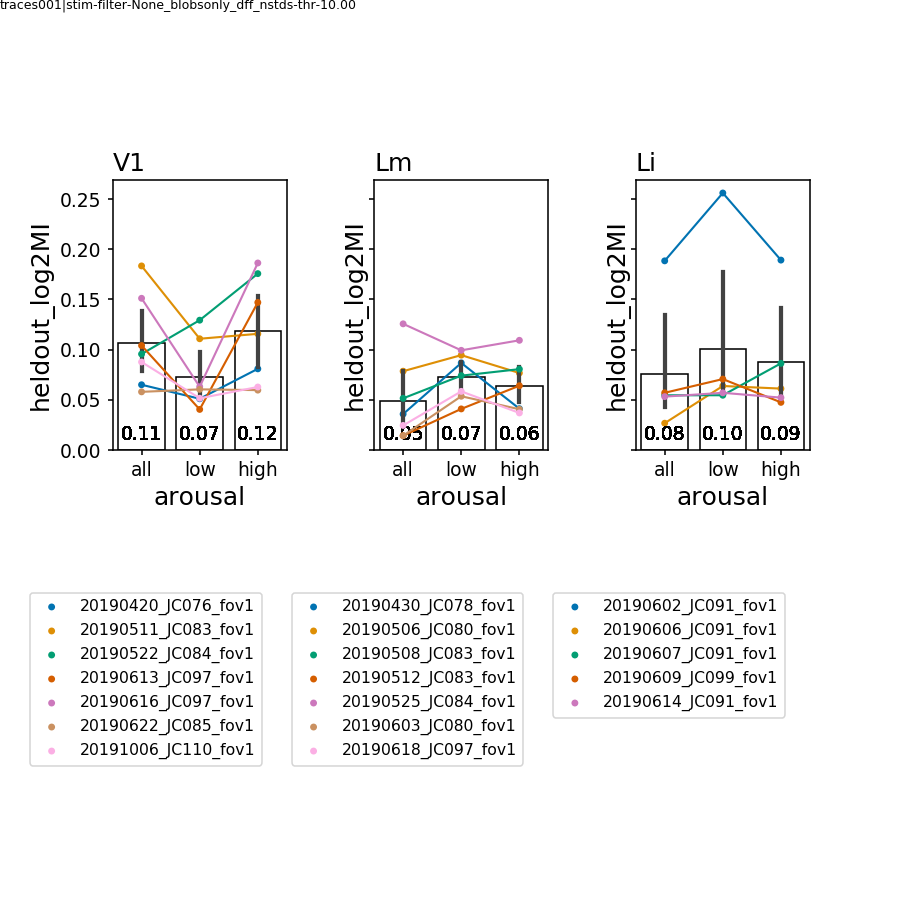

('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding', 'heldout_log2MI_overlap-thr-0.80_pupil_area_by-area_min-20-cells')


In [278]:
#few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']
skip = ['20190507_JC083_fov1', '20190617_JC097_fov1', '20190510_JC083_fov1'] #,
       #'20190618_JC097_fov1', '20190508_JC083_fov1']
# skip=[]
skip.extend(too_few)

#metric='heldout_test_score'
metric='heldout_log2MI'

plotdf = df[~df['datakey'].isin(skip)]

ai=0
fig, axn = pl.subplots(1, 3, figsize=(8,8), dpi=dpi, sharex=True, sharey=True)
for ax, (visual_area, a_df) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                     s=10, join=True, scale=0.5)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')

    ax.set_title(visual_area, loc='left', fontsize=16)
    #ax.axhline(y=0.5, color='k', linestyle=':')
    
    ax.legend(bbox_to_anchor=(0.9, -0.5))
    ai+=1
    
pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
#sns.despine(trim=True)

pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
#sns.despine(trim=True)

putils.label_figure(fig, data_id)
figname = '%s_overlap-thr-%.2f_%s_by-area_min-%i-cells' % (metric, overlap_thr, face_feature, min_ncells)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
print(decoding_dir, figname)

<IPython.core.display.Javascript object>


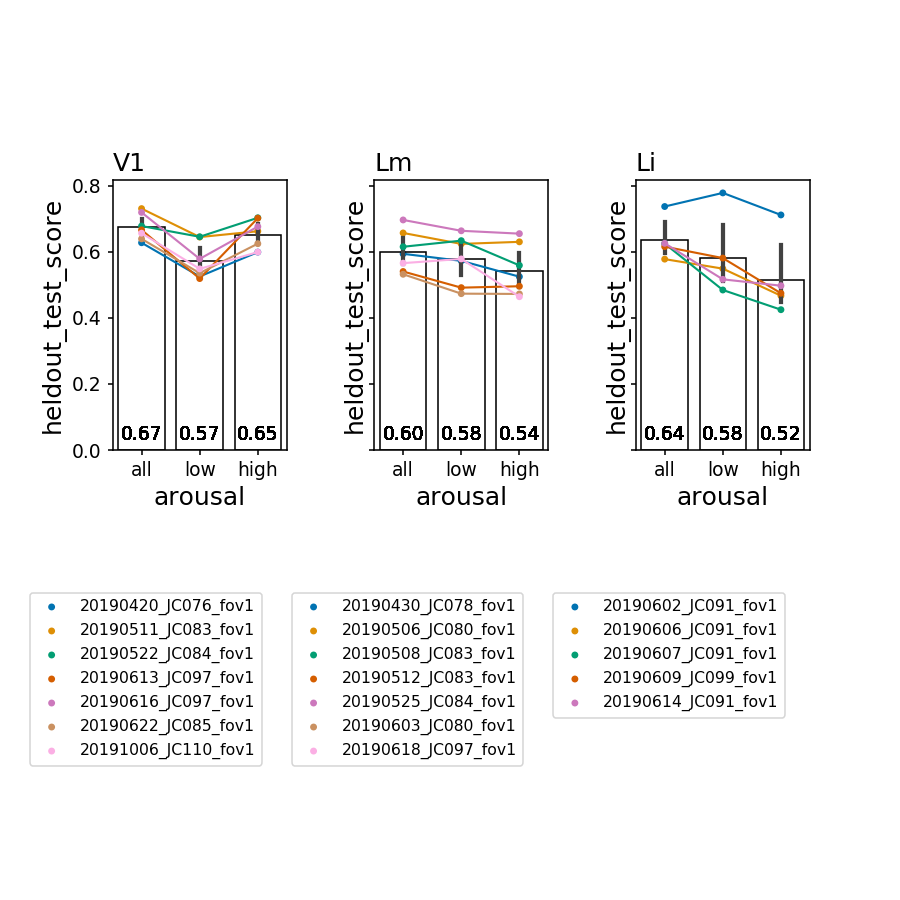

In [192]:
#few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']
skip = ['20190507_JC083_fov1', '20190617_JC097_fov1', '20190510_JC083_fov1'] #,
       #'20190618_JC097_fov1', '20190508_JC083_fov1']
# skip=[]
skip.extend(too_few)

metric='heldout_test_score'
#metric='heldout_log2MI'

plotdf = df[~df['datakey'].isin(skip)]

ai=0
fig, axn = pl.subplots(1, 3, figsize=(8,8), dpi=dpi, sharex=True, sharey=True)
for ax, (visual_area, a_df) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                     s=10, join=True, scale=0.5)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')

    ax.set_title(visual_area, loc='left', fontsize=16)
    #ax.axhline(y=0.5, color='k', linestyle=':')
    
    ax.legend(bbox_to_anchor=(0.9, -0.5))
    ai+=1
    
pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
#sns.despine(trim=True)

cell_counts


In [237]:
metric = 'heldout_test_score'

d_list=[]; d_list_chance=[]; dkeys=[]; vkeys=[];
lo_list=[]; lo_list_chance=[]; 
hi_list=[]; hi_list_chance=[]; 

n_datakeys = len(pass_dsets['datakey'].unique())
for di, ((visual_area, datakey), ds) in enumerate(pass_dsets.groupby(['visual_area', 'datakey'])):
    if datakey in too_few_cells:
        print("(%s) Too few pass: %i"% (datakey, len(ds['cell'].unique())))
        continue

    if di % 5 == 0:
        print("%i of %i datakeys" % (int(di+1), n_datakeys))
    
    # ------ Neural ----------------------------------------------
    # Only select cells that pass conditions
    print("**** [%s] %s *****" % (visual_area, datakey))
    config_list = MEANS[datakey]['config']
    roi_list = ds['cell'].unique()
    ncells_t = MEANS[datakey].shape[1]-1
    neuraldf = MEANS[datakey][roi_list].copy() 
    neuraldf['config'] = config_list
    # sdf = SDF[datakey].copy()
    print("... (%s | %s) %i of %i cells" % (visual_area, datakey, len(roi_list), ncells_t))    
    
    # ------ PUPIL --------------------------------------------------
    pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()

    #### Resample pupil
    desired_nframes = 60 #len(out_ixs) # 60
    binned_pupil = bin_pupil_traces(pupiltraces, in_rate=20.0, out_rate=new_framerate, 
                                         min_nframes=desired_nframes)
    trials_ = sorted(pupiltraces['trial'].unique())
    frames_ = np.arange(0, desired_nframes)
    pupil_trialmat = pd.DataFrame(np.vstack([p['pupil'].values for trial, p in binned_pupil.groupby(['trial'])]),
                                  index=trials_, columns=frames_)
    pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
    pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
    
    # ------ Split trials by quantiles ---------------------------------
    pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])
    low_pupil_thr = pupil_quantiles[0.25]
    high_pupil_thr = pupil_quantiles[0.75]
    pupil_low = pupildf[pupildf['pupil']<=low_pupil_thr].copy()
    pupil_high = pupildf[pupildf['pupil']>=high_pupil_thr].copy()

    # Get trial indices of low/high pupil 
    low_trial_ixs = sorted(pupil_low['trial'].unique())
    high_trial_ixs = sorted(pupil_high['trial'].unique())
    
    # Fit all
    curr_data = neuraldf.copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("all: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
    d_list.append(df.mean(axis=0).T)
    d_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[low_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("low: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
    lo_list.append(df.mean(axis=0).T)
    lo_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[high_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("high: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
    hi_list.append(df.mean(axis=0).T)
    hi_list_chance.append(df_chance.mean(axis=0).T)
    
    dkeys.append(datakey)
    vkeys.append(visual_area)

(20190502_JC076_fov1) Too few pass: 14
**** [Li] 20190602_JC091_fov1 *****
... (Li | 20190602_JC091_fov1) 57 of 241 cells
all: 0.76 (chance=0.49)
low: 0.72 (chance=0.51)
high: 0.75 (chance=0.51)
(20190605_JC090_fov1) Too few pass: 8
**** [Li] 20190606_JC091_fov1 *****
... (Li | 20190606_JC091_fov1) 21 of 136 cells
all: 0.58 (chance=0.49)
low: 0.44 (chance=0.56)
high: 0.44 (chance=0.51)
**** [Li] 20190609_JC099_fov1 *****
... (Li | 20190609_JC099_fov1) 20 of 78 cells
all: 0.61 (chance=0.51)
low: 0.49 (chance=0.52)
high: 0.48 (chance=0.48)
(20190617_JC099_fov1) Too few pass: 1
(20191018_JC113_fov1) Too few pass: 5
(20191111_JC120_fov1) Too few pass: 1
**** [Lm] 20190430_JC078_fov1 *****
... (Lm | 20190430_JC078_fov1) 24 of 187 cells
all: 0.59 (chance=0.49)
low: 0.55 (chance=0.51)
high: 0.53 (chance=0.46)
(20190504_JC078_fov1) Too few pass: 8
11 of 24 datakeys
**** [Lm] 20190506_JC080_fov1 *****
... (Lm | 20190506_JC080_fov1) 27 of 226 cells
all: 0.67 (chance=0.51)
low: 0.70 (chance=0.51)

In [238]:
print(d_list[0].shape)
full_df = pd.concat(d_list, axis=1).T
full_chance = pd.concat(d_list_chance, axis=1).T
full_df['datakey'] = dkeys
full_chance['datakey'] = dkeys
full_df['visual_area'] = vkeys
full_chance['visual_area'] = vkeys

lo_df = pd.concat(lo_list, axis=1).T
lo_chance = pd.concat(lo_list_chance, axis=1).T
lo_df['datakey'] = dkeys
lo_chance['datakey'] = dkeys
lo_df['visual_area'] = vkeys
lo_chance['visual_area'] = vkeys

hi_df = pd.concat(hi_list, axis=1).T
hi_chance = pd.concat(hi_list_chance, axis=1).T
hi_df['datakey'] = dkeys
hi_chance['datakey'] = dkeys
hi_df['visual_area'] = vkeys
hi_chance['visual_area'] = vkeys


(12,)


<IPython.core.display.Javascript object>


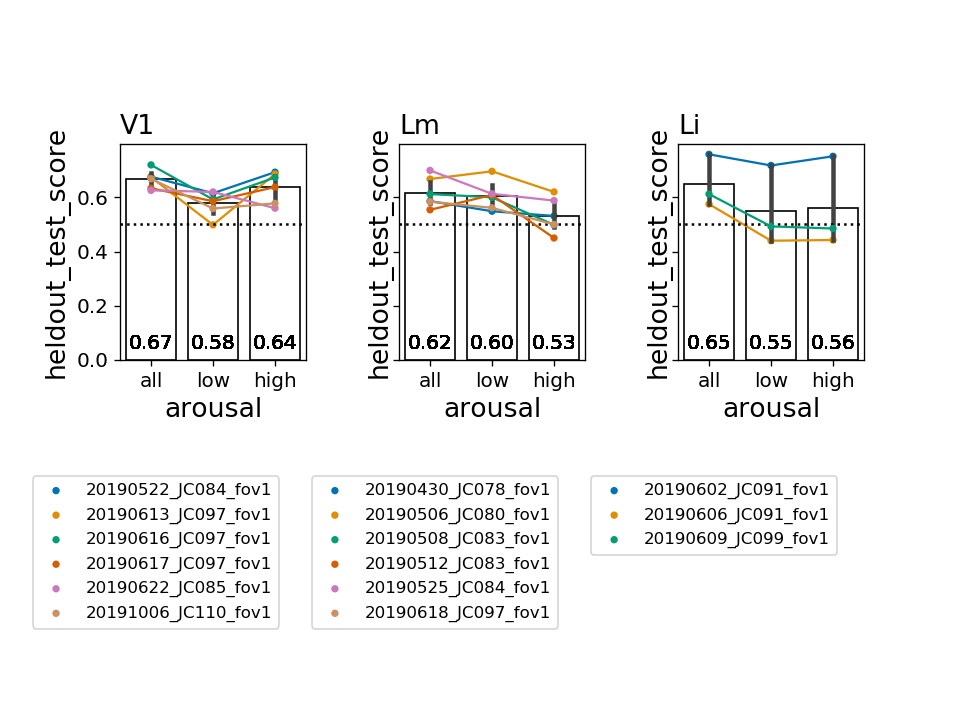

In [254]:
few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']
skip = ['20190507_JC083_fov1', '20190420_JC076_fov1']

metric='heldout_test_score'
#metric='heldout_aMI'

m_ = pd.concat([full_df[metric], lo_df[metric], hi_df[metric]], axis=1)
m_.columns = ['all', 'low', 'high']
# m_df['datakey'] = full_df['datakey']
m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})

m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
#m_df['visual_area'] = [full_df.loc[i]['visual_area'] for i in m_df['datakey']]
v_labels = pd.concat([full_df['visual_area'], lo_df['visual_area'], hi_df['visual_area']], axis=0).values
m_df['visual_area'] = v_labels

plotdf = m_df[~m_df['datakey'].isin(skip)]

# plot
ai=0
fig, axn = pl.subplots(1, 3, figsize=(8,6), dpi=dpi, sharex=True, sharey=True)
for ax, (visual_area, a_df) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                 s=10, join=True, scale=0.5)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')

    ax.set_title(visual_area, loc='left', fontsize=16)
    ax.axhline(y=0.5, color='k', linestyle=':')
    
    ax.legend(bbox_to_anchor=(0.9, -0.5))
    ai+=1
    
pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
#sns.despine(trim=True)

<IPython.core.display.Javascript object>


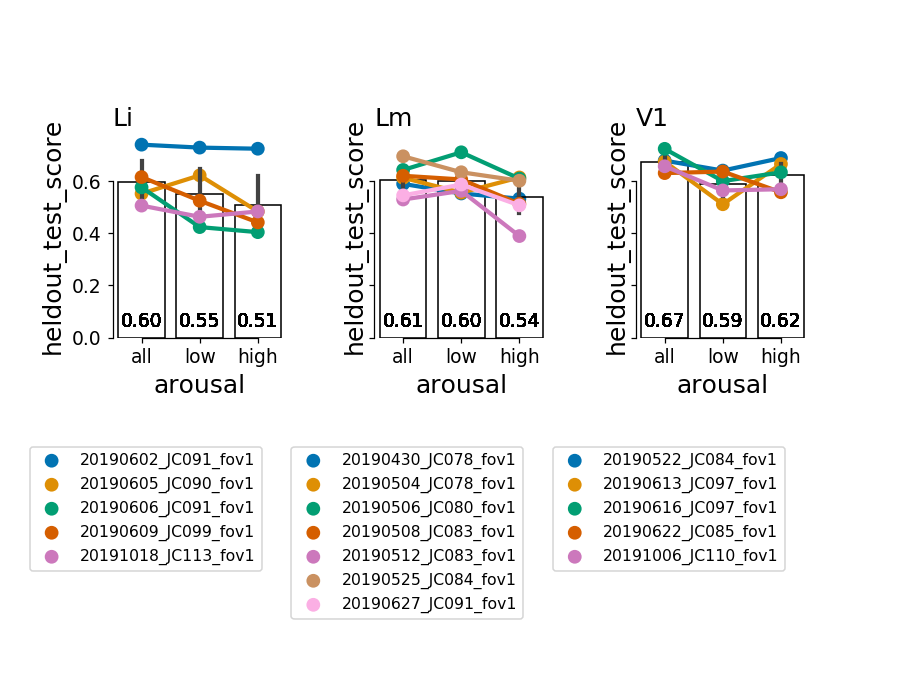

In [123]:
few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']
metric='heldout_test_score'
#metric='heldout_aMI'

m_ = pd.concat([full_df[metric], lo_df[metric], hi_df[metric]], axis=1)
m_.columns = ['all', 'low', 'high']
# m_df['datakey'] = full_df['datakey']
m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})

m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
#m_df['visual_area'] = [full_df.loc[i]['visual_area'] for i in m_df['datakey']]
v_labels = pd.concat([full_df['visual_area'], lo_df['visual_area'], hi_df['visual_area']], axis=0).values
m_df['visual_area'] = v_labels

plotdf = m_df[~m_df['datakey'].isin(few)]

# plot
ai=0
fig, axn = pl.subplots(1, 3, figsize=(8,6), dpi=dpi, sharex=True, sharey=True)
for ax, (visual_area, a_df) in zip(axn.flat, plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                 s=10, join=True)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    #ax.legend(bbox_to_anchor=(1.1, 1))
#     if ai!=2:
#         ax.legend_.remove()
#     else:
    ax.set_title(visual_area, loc='left', fontsize=16)
    
    ax.legend(bbox_to_anchor=(0.9, -0.5))
    ai+=1
pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
sns.despine(trim=True)

In [202]:
few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']

<IPython.core.display.Javascript object>


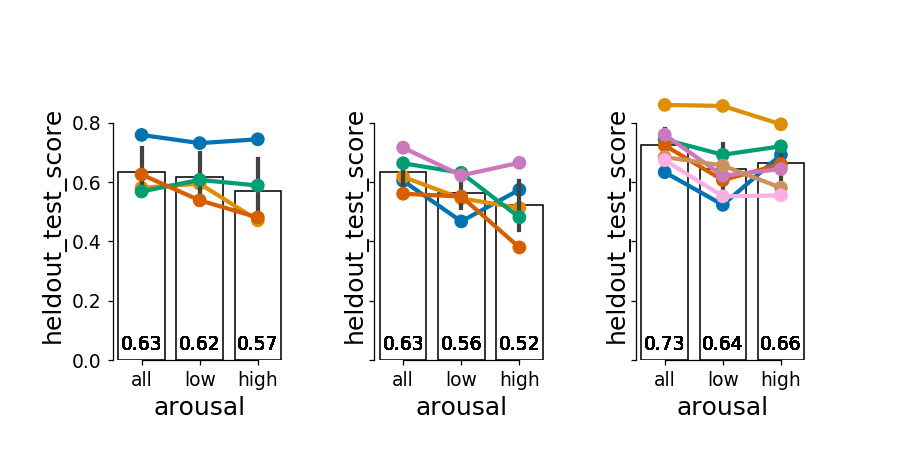

In [203]:
metric='heldout_test_score'

m_ = pd.concat([full_df[metric], lo_df[metric], hi_df[metric]], axis=1)
m_.columns = ['all', 'low', 'high']
# m_df['datakey'] = full_df['datakey']
m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})

m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
#m_df['visual_area'] = [full_df.loc[i]['visual_area'] for i in m_df['datakey']]
v_labels = pd.concat([full_df['visual_area'], lo_df['visual_area'], hi_df['visual_area']], axis=0).values
m_df['visual_area'] = v_labels

plotdf = m_df[~m_df['datakey'].isin(few)]

# plot
fig, axn = pl.subplots(1, 3, figsize=(8,4), dpi=dpi, sharex=True, sharey=True)
for ax, (arousal, a_df) in zip(axn.flat, plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                 s=10, join=True)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    #ax.legend(bbox_to_anchor=(1.1, 1))
    ax.legend_.remove()
pl.subplots_adjust(wspace=0.5, bottom=0.2, top=0.8)
sns.despine(trim=True)

In [101]:
def filter_rois(has_blobs, overlap_thr=0.50):
    visual_areas=['V1', 'Lm', 'Li']
    nocells=[]; notrials=[];
    global_rois = dict((v, []) for v in visual_areas)
    roi_counters = dict((v, 0) for v in visual_areas)
    roidf = []
    datakeys = dict((v, []) for v in visual_areas)
    
    for (visual_area, datakey), g in has_blobs[has_blobs['perc_overlap']>=overlap_thr].groupby(['visual_area', 'datakey']):

        roi_counter = roi_counters[visual_area]
        datakeys[visual_area].append(datakey)

        #ddf.sort_values(by='config')
        roi_list = sorted([s for s in g['cell'].unique()]) #[int(r) for r in ddf.columns if r != 'config']

        # Reindex roi ids for global
        roi_ids = [i+roi_counter for i, r in enumerate(roi_list)]
        nrs = len(roi_list)

        global_rois[visual_area].extend(roi_ids)
        roidf.append(pd.DataFrame({'roi': roi_ids,
                                   'dset_roi': roi_list,
                                   'visual_area': [visual_area for _ in np.arange(0, nrs)],
                                   'datakey': [datakey for _ in np.arange(0, nrs)]}))

        # Update global roi id counter
        roi_counters[visual_area] += len(roi_ids)

    roidf = pd.concat(roidf, axis=0) #.groupby(['visual_area']).count()
    #print("%i datasets fail all thresholds:" % len(nocells), nocells)
    for k, v in global_rois.items():
        print(k, len(v))
        
    return roidf